In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/prostate.h5ad'

adata = sc.read_h5ad(results_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
# subset to lymphoid cells
adata = adata[adata.obs['celltype'].isin(['T cell', 'B cell', 'NK cell'])]
adata

View of AnnData object with n_obs × n_vars = 3683 × 1487 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
# make a version to separate patient D6 (BN+PIN) and also D7 and D14 (low numbers)
adata = adata[~adata.obs['patient'].isin(['D7','D6','D14'])]

In [4]:
# start from the raw counts
adata = sc.AnnData(adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns)
adata.raw = adata

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


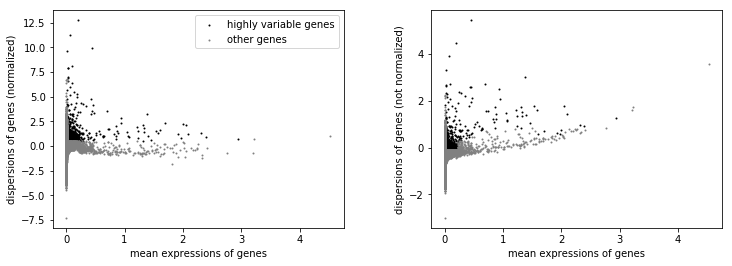

In [5]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# plot highly_variable_genes
sc.pl.highly_variable_genes(adata)

In [6]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


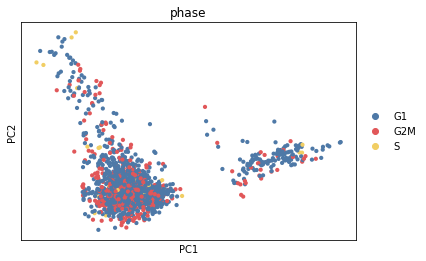

In [7]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver = 'arpack', n_comps = 50)
sc.pl.pca(adata, color = 'phase')

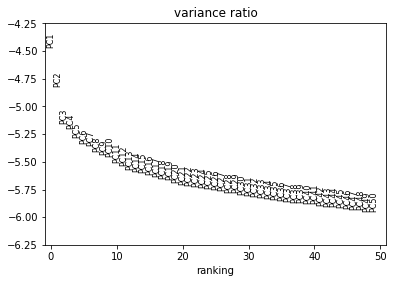

In [8]:
# Principal component analysis
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


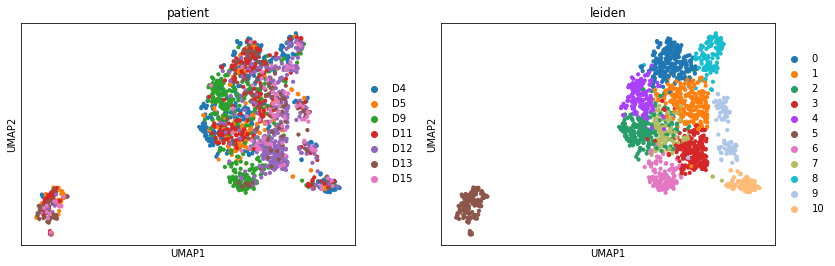

In [9]:
# Computing the neighborhood graph. Seurat uses k = 20 as default
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 50)
# run UMAP
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata)
# plotting groups and clusters
sc.pl.umap(adata, color = ['patient', 'leiden'])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


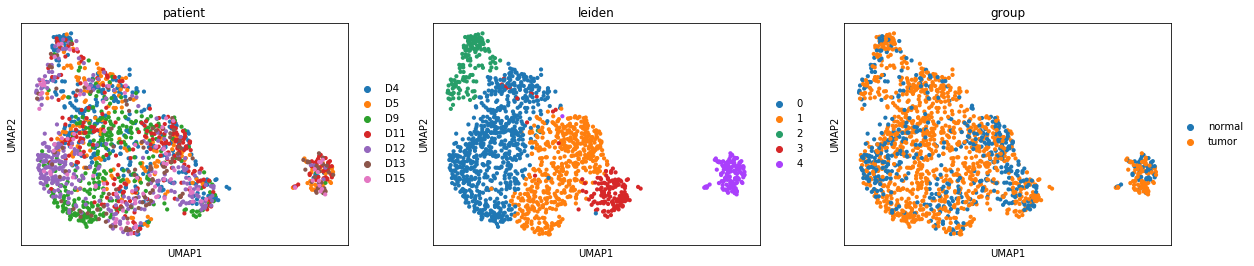

In [10]:
# batch correction using bbknn
sc.external.pp.bbknn(adata, batch_key = 'patient')
# rerun umap
sc.tl.umap(adata, n_components = 2, min_dist = 0.3)
# find clusters
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color = ['patient', 'leiden', 'group'])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

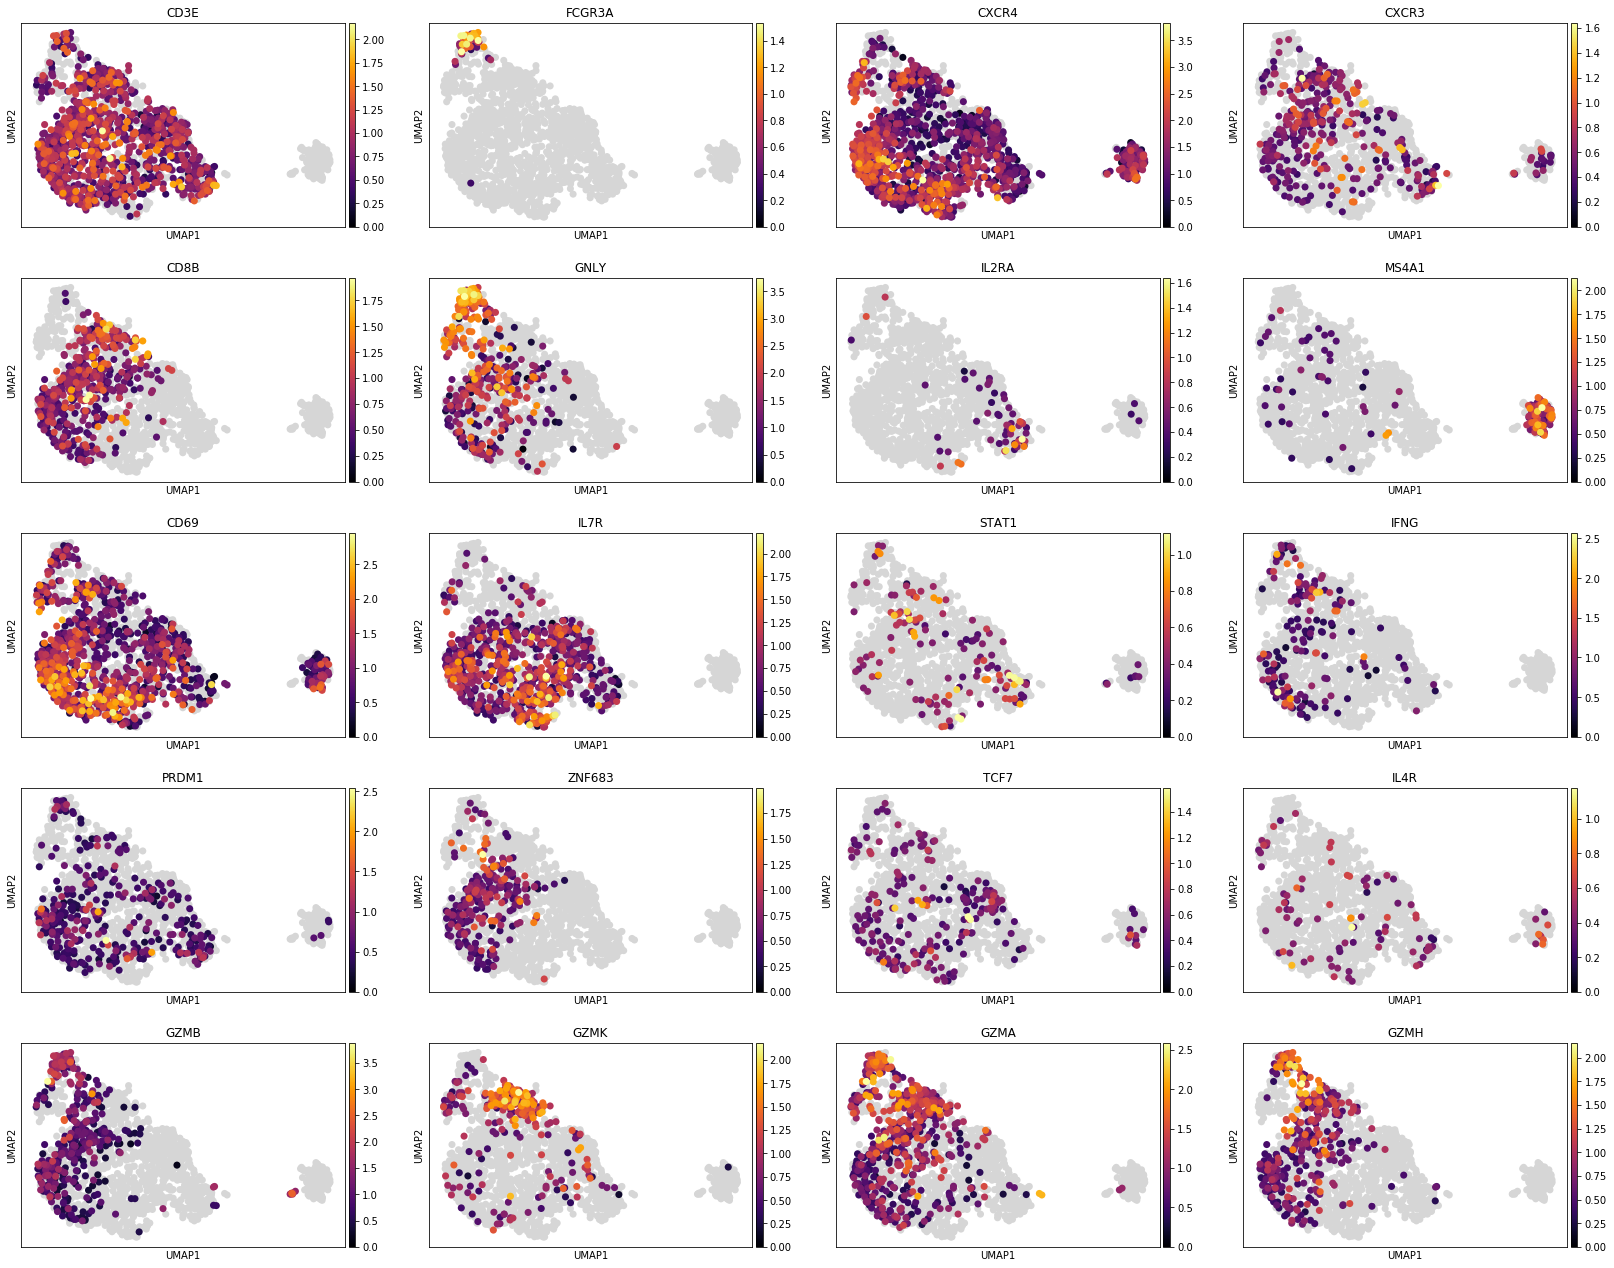

In [12]:
sc.pl.umap(adata, color = ['CD3E', 'FCGR3A', 'CXCR4', 'CXCR3', 'CD8B', 'GNLY', 'IL2RA', 'MS4A1', 'CD69', 'IL7R', 'STAT1', 'IFNG', 'PRDM1', 'ZNF683', 'TCF7', 'IL4R', 'GZMB', 'GZMK', 'GZMA', 'GZMH'], size =200, color_map = newcmp)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


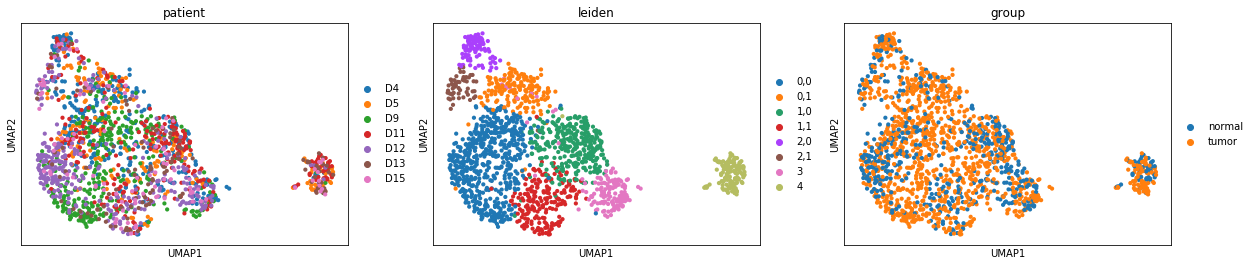

In [13]:
sc.tl.leiden(adata, resolution = 0.3, restrict_to=('leiden', ['0']), key_added = 'leiden')
sc.tl.leiden(adata, resolution = 0.3, restrict_to=('leiden', ['1']), key_added = 'leiden')
sc.tl.leiden(adata, resolution = 0.3, restrict_to=('leiden', ['2']), key_added = 'leiden')
sc.pl.umap(adata, color = ['patient', 'leiden', 'group'])

In [14]:
# try gene set test with Dona Farber's recent paper
modules = pd.read_csv('dataset/Szabo et al T cell gene module.txt', sep = '\t')
for gs in modules.columns:
    sc.tl.score_genes(adata, modules[gs], score_name = str(gs)+'_score', use_raw=True)

computing score 'Treg_score'
    finished: added
    'Treg_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 NV/CM rest_score'
    finished: added
    'CD4 NV/CM rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4/CD8 rest_score'
    finished: added
    'CD4/CD8 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'IFN Response_score'
    finished: added
    'IFN Response_score', score of gene set (adata.obs) (0:00:00)
computing score 'Proliferation_score'
    finished: added
    'Proliferation_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytotoxic_score'
    finished: added
    'CD8 Cytotoxic_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 Cytokine_score'
    finished: added
    'CD8 Cytokine_score', score of gene set (adata.obs) (0:00:00)


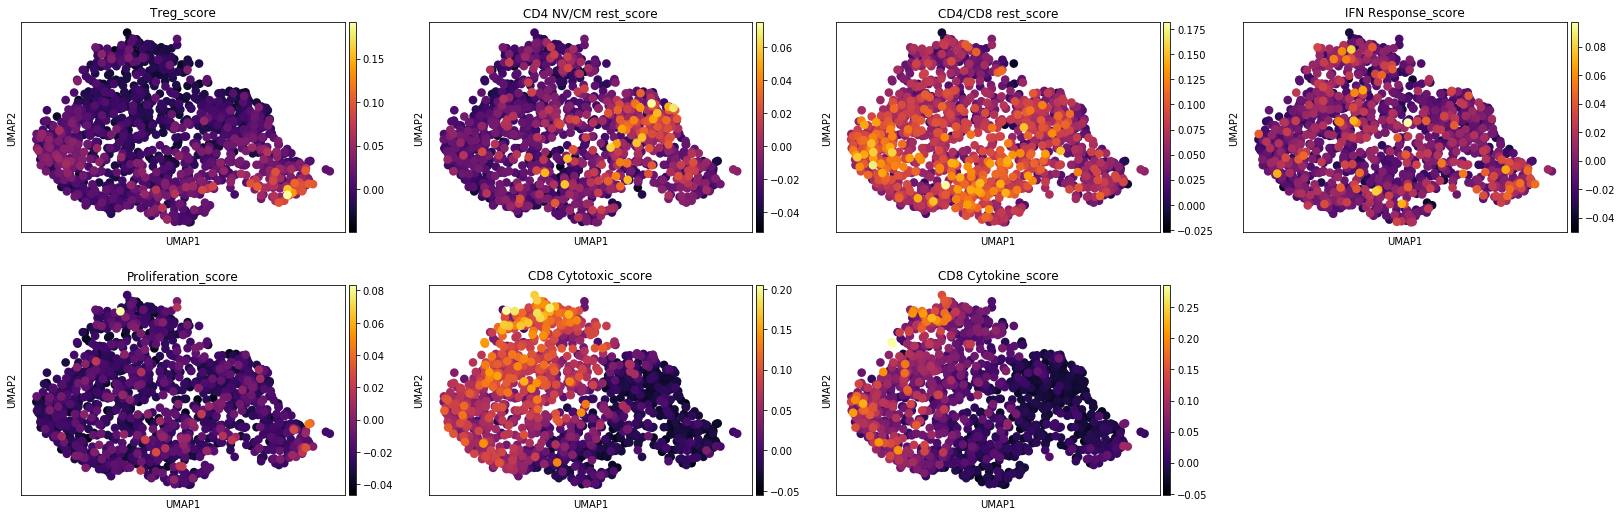

In [15]:
sc.pl.umap(adata[~adata.obs['leiden'].isin(['2,0','2,1', '4'])], color = [str(gs)+'_score' for gs in modules.columns], color_map = 'inferno', size = 300)

In [56]:
Kumar_Trm_signature = {'CD69+Trm':['CA10','ITGAE1','ITGAE','IL2','IL10','CXCR6','CXCL13','KCNK5','RGS1','CRTAM','DUSP6','PDCD1','IL23R'],
    'CD69-Trm':['STK38','TTC16','SELL','KLF3','KLF2','D4S234E','SBK1','FAM65B','TTYH2','NPDC1','KRT72','S1PR1','SOX13','KRT73','TSPAN18','PTGDS','RAP1GAP2','CX3CR1']}
Mackay_Trm_signature={
    'Trm':['INSIG1', 'DDX3X', 'DHCR24', 'PPP1R16B', 'KLF6', 'BTG2', 'CXCR6', 'FOSB', 'JUN', 'HSPA5', 'NEDD4', 'PLK3', 'STARD4', 'TNFAIP3', 'B4GALNT4', 'IRF4', 'CISH', 'MAPKAPK3', 'SIK1', 'PYGL', 'CTNNA1', 'ODC1', 'PER1', 'DUSP1', 'ATF3', 'LDLRAD4', 'JUNB', 'NFKBID', 'FOSL2', 'RGS2', 'NR4A2', 'DGAT1', 'ARRDC3', 'FRMD4B', 'NR4A1', 'GPR171', 'SMIM3', 'EYA2', 'GPR55', 'AL662899.4', 'CSRNP1', 'TRAF4', 'ZFP36', 'GLRX', 'DUSP5', 'LITAF', 'GADD45B', 'IFNG', 'OSGIN1', 'ABI3', 'EGR1', 'HILPDA', 'SKIL', 'RNF149', 'HMGCS1', 'P4HB', 'PNRC1', 'GPR34', 'PPP1R15A', 'ITGAE', 'P2RY10', 'EHD1', 'DUSP6', 'XCL2', 'SPSB1', 'ISG20', 'INPP4B', 'NEURL3', 'HPGDS', 'RHOB', 'VDAC1', 'LAD1', 'FOS', 'CDH1', 'CD69', 'QPCT', 'HSPD1'],
    'Tcm/Tem':['HBA2', 'C19orf38', 'SNX10', 'HAAO', 'POGK', 'SBK1', 'KLF2', 'BCL9L', 'THAP7', 'ASRGL1', 'ELMO1', 'HEXB', 'RACGAP1', 'CXCR4', 'CDC25B', 'LFNG', 'S1PR5', 'ARHGAP26', 'MPND', 'KCNAB2', 'ATP1B3', 'S1PR4', 'TMEM71', 'KBTBD11', 'EMB', 'MS4A4A', 'GRAMD4', 'EHD3', 'KCNN4', 'TCF7', 'MS4A4A', 'PAQR7', 'FAM89B', 'LYST', 'GLIPR2', 'EML3', 'S1PR1', 'PIK3R5', 'SETX', 'TXNDC5', 'NCLN', 'STK38', 'ITGA4', 'CCL5', 'CD84', 'KLF3', 'ABTB2', 'TBXA2R', 'LYRM2', 'OBP2B', 'ACP5', 'PODNL1', 'LEF1', 'SH2D1A', 'PHF11', 'TSR3', 'GMFG', 'EOMES', 'GNPDA2', 'PDE2A', 'SIDT1', 'GAB3', 'TXK', 'AVEN', 'ICAM2', 'KLHL6', 'SAMHD1', 'SMPDL3B', 'TTC7B', 'C5orf30', 'ATP10D', 'ST3GAL1', 'VOPP1', 'PCED1B', 'DOCK2', 'ITGB1', 'FAM117A', 'IL10RA', 'LPIN1', 'RBM43', 'ARHGEF18', 'RASA3', 'ABHD8', 'FAM49A', 'RASGRP2', 'B3GAT3', 'PRKCQ', 'XRN2']}
tcell_markers = {
    'CD4 rest':['TCF7', 'ID3', 'CCR7', 'AQP3', 'SELL'],
    'CD4 act\n':['IL4R', 'STAT1', 'MAL', 'SOCS1', 'IL2', 'ODC1', 'PSAT1', 'WARS', 'PYCR1', 'TNF', 'MIR155HG', 'NME1'],
    'CD4 Trm rest':['IFI6', 'LGALS3'],
    'CD4 Trm act\n':['MAF', 'TNFRSF18'],
    'CD8 EM/Trm rest':['KLRB1', 'JAML'],
    'CD8 Trm rest\n':['PDZD8', 'CXCR6', 'RCAN2', 'PRF1', 'ANXA2', 'CRIP1', 'ITGA1'],
    'CD8 EM/Trm act':['GZMB', 'IFNG', 'HOPX', 'CCL4', 'CCL3', 'XCL1', 'NKG7', 'GZMK', 'PRF1', 'GNLY', 'IFIT3', 'KLRD1', 'MYO1F', 'CCL5', 'GZMH', 'XCL2']}

In [57]:
for gs in Kumar_Trm_signature:
    sc.tl.score_genes(adata, Kumar_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in Mackay_Trm_signature:
    sc.tl.score_genes(adata, Mackay_Trm_signature[gs], score_name = str(gs)+'_score', use_raw=True)
for gs in tcell_markers:
    sc.tl.score_genes(adata, tcell_markers[gs], score_name = str(gs)+'_score', use_raw=True)    

computing score 'CD69+Trm_score'
    finished: added
    'CD69+Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD69-Trm_score'
    finished: added
    'CD69-Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Trm_score'
    finished: added
    'Trm_score', score of gene set (adata.obs) (0:00:00)
computing score 'Tcm/Tem_score'
    finished: added
    'Tcm/Tem_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 rest_score'
    finished: added
    'CD4 rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 act\n_score'
    finished: added
    'CD4 act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm rest_score'
    finished: added
    'CD4 Trm rest_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD4 Trm act\n_score'
    finished: added
    'CD4 Trm act\n_score', score of gene set (adata.obs) (0:00:00)
computing score 'CD8 EM/Trm rest_score'
    finished: added
    'CD8 EM/

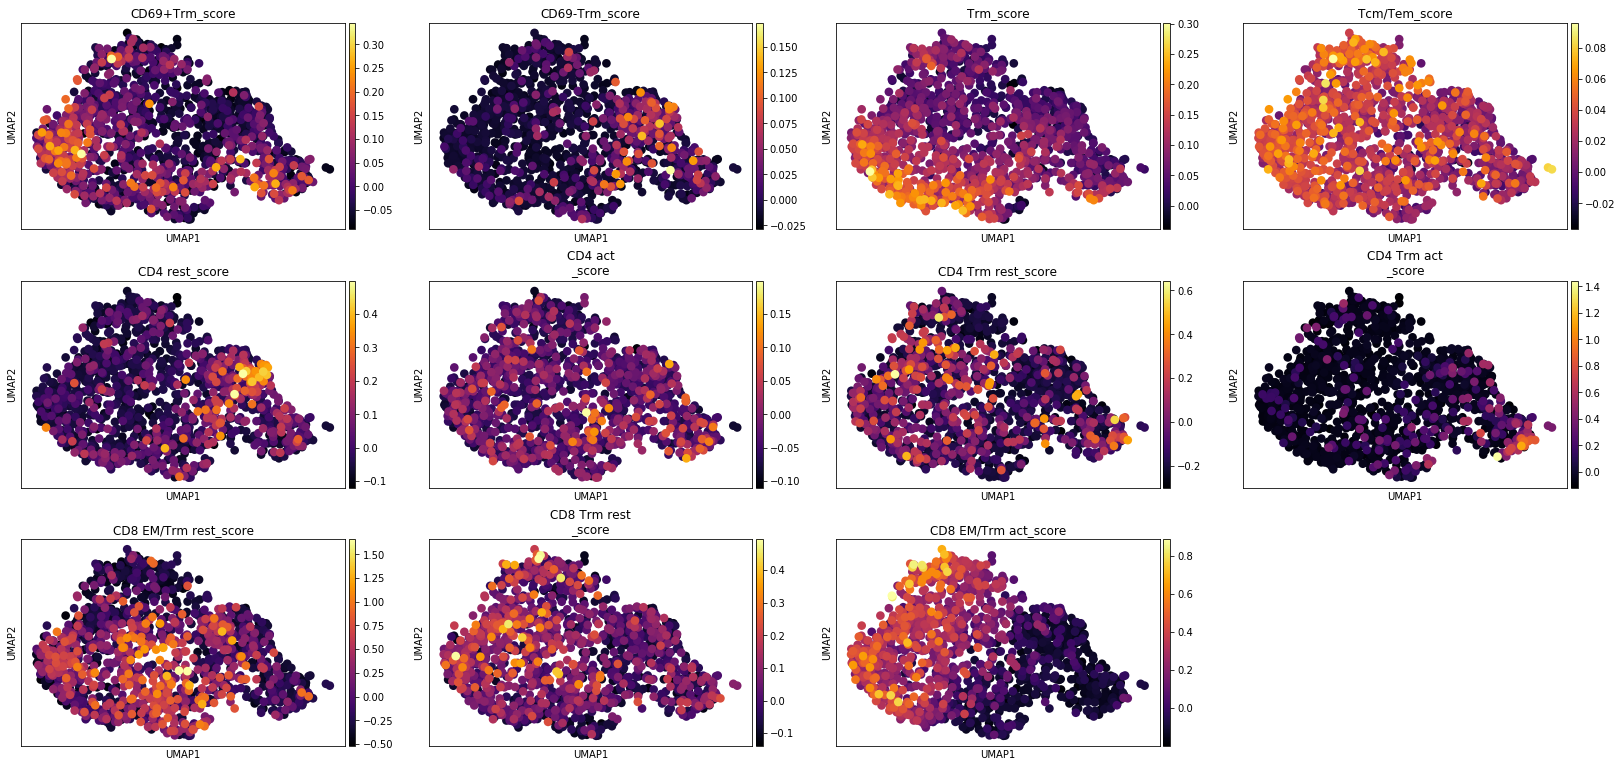

In [58]:
sc.pl.umap(adata[~adata.obs['leiden'].isin(['2,0','2,1', '4'])], color = [str(gs)+'_score' for gs in Kumar_Trm_signature]+[str(gs)+'_score' for gs in Mackay_Trm_signature]+[str(gs)+'_score' for gs in tcell_markers], color_map = 'inferno', size = 300)

In [19]:
genesets = pd.read_csv('dataset/Mouse_exhaustion_genesets_converted.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(adata, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

computing score 'GSE41867 Chronic-acute CD8+ Up_score'
    finished: added
    'GSE41867 Chronic-acute CD8+ Up_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE41870 CD8+ LCMV Chronic-Acute UP_score'
    finished: added
    'GSE41870 CD8+ LCMV Chronic-Acute UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score'
    finished: added
    'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', score of gene set (adata.obs) (0:00:00)


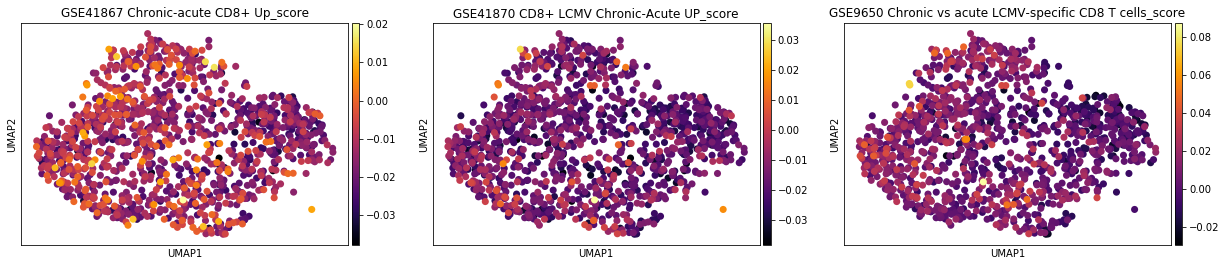

In [20]:
sc.pl.umap(adata[~adata.obs['leiden'].isin(['2,0','2,1', '3', '4'])], color = [str(gs)+'_score' for gs in genesets.columns], color_map = 'inferno', size = 200)

... storing 'celltype-immune_group' as categorical


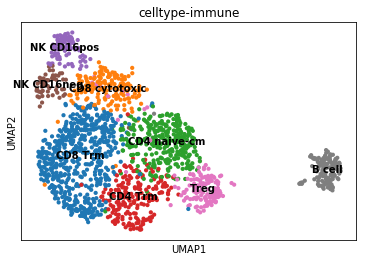

In [23]:
celltype_immune = {'0,0':'CD8 Trm', '0,1':'CD8 cytotoxic', '1,0':'CD4 naive-cm', '1,1':'CD4 Trm', '2,0':'NK CD16pos', '2,1':'NK CD16neg', '3':'Treg', '4':'B cell'}
adata.obs['celltype-immune'] = [celltype_immune[l] for l in adata.obs['leiden']]
adata.obs['celltype-immune'] = adata.obs['celltype-immune'].astype('category')
adata.obs['celltype-immune'].cat.reorder_categories(['CD8 Trm','CD8 cytotoxic','CD4 naive-cm','CD4 Trm','NK CD16pos','NK CD16neg','Treg','B cell'], inplace=True)
sc.pl.umap(adata, color = 'celltype-immune', legend_loc = 'on data')
adata.obs['celltype-immune_group'] = [c+'_'+g for c,g in zip(adata.obs['celltype-immune'],adata.obs['group'])]

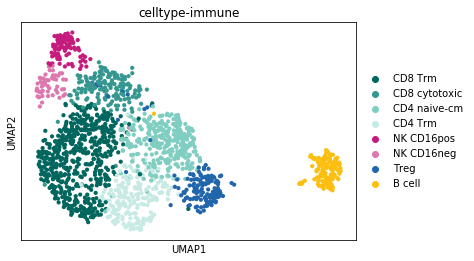

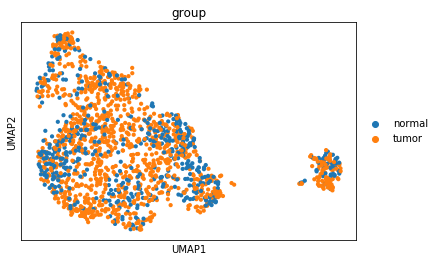

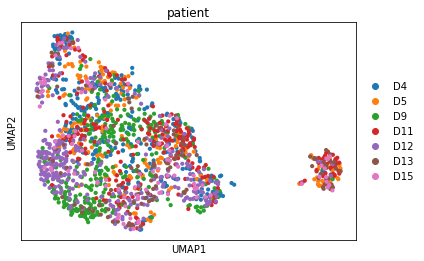

In [44]:
sc.pl.umap(adata, color = ['celltype-immune'], save = '/lymphoid_celltypes.pdf', palette = ['#01665e', '#35978f', '#80cdc1', '#c7eae5', '#c51b7d', '#de77ae', '#2166ac', '#fcbf10'])
sc.pl.umap(adata, color = ['group'], save = '/lymphoid_group.pdf')
sc.pl.umap(adata, color = ['patient'], save = '/lymphoid_patient.pdf')

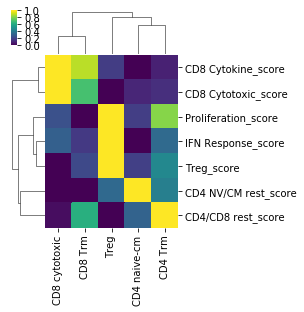

In [62]:
# calculate average enrichment score
adata2 = adata[~adata.obs['leiden'].isin(['2,0','2,1', '4'])]
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['celltype-immune'] + [str(gs)+'_score' for gs in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetX = subset[subset['celltype-immune'] == x]
    outdict = {}
    for k in [str(gs)+'_score' for gs in modules.columns]:
        out = {k:np.mean(subsetX[k])}
        outdict.update(out)
    output = output.append(outdict, ignore_index=True)
output.index = list1
g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score.pdf')

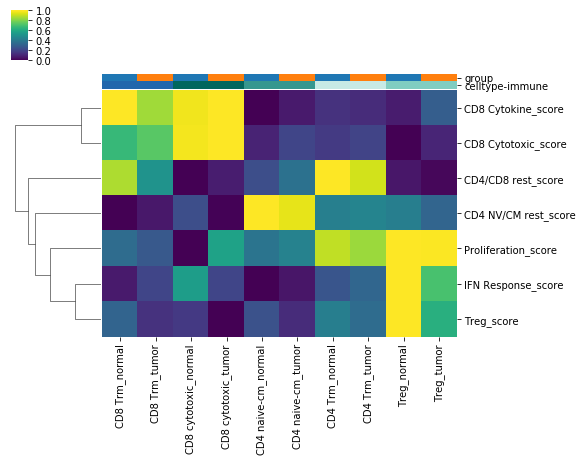

In [52]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, len(list1)) for x in adata2.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata2.uns['celltype-immune_colors']) + list(adata2.uns['celltype-immune_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'celltype-immune']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 cytotoxic_normal', 'CD8 cytotoxic_tumor', 'CD4 naive-cm_normal', 'CD4 naive-cm_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_split.pdf')

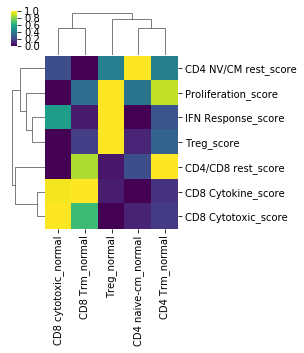

In [53]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_normal.pdf')

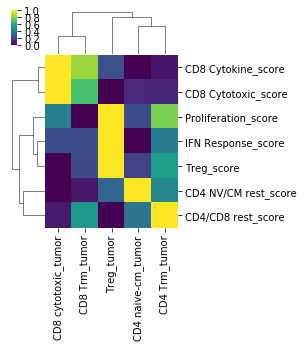

In [54]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in modules.columns]]
output = pd.DataFrame()
for x in list1:
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictT = {}
    for k in [str(m)+'_score' for m in modules.columns]:
        outT = {k:np.mean(subsetT[k])}
        outdictT.update(outT)
    output = output.append(outdictT, ignore_index=True)
output.index = [l + '_tumor' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_geneset_score_tumor.pdf')

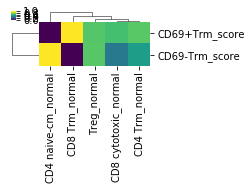

In [64]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in Kumar_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Kumar_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Kumar_Trm_geneset_score_normal.pdf')

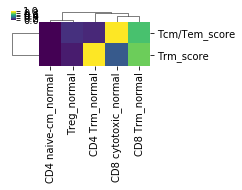

In [65]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in Mackay_Trm_signature]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in Mackay_Trm_signature]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(2.5, 1))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Mackay_Trm_geneset_score_normal.pdf')

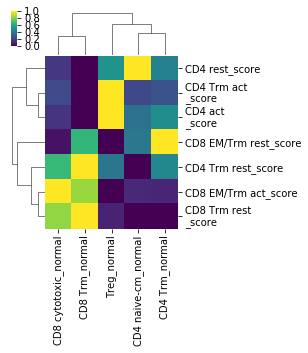

In [63]:
# calculate average enrichment score
list1 = list(set(adata2.obs['celltype-immune']))
subset = adata2.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in tcell_markers]]
output = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    outdictN = {}
    for k in [str(m)+'_score' for m in tcell_markers]:
        outN = {k:np.mean(subsetN[k])}
        outdictN.update(outN)
    output = output.append(outdictN, ignore_index=True)
output.index = [l + '_normal' for l in list1]

g = sns.clustermap(output.transpose(), standard_scale = 0, cmap="viridis", figsize=(3, 4))
if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Szabo_tcell_marker_score_normal.pdf')

In [66]:
# test geneset NK cell mediated cytotoxicity from GO
modules = {'NK cell-mediated cytotoxicity':['AP1G1', 'ARRB2', 'CADM1', 'CD160', 'CD226', 'CEACAM1', 'CEBPG', 'CLEC12B', 'CLEC2A', 'CORO1A', 'CRK', 'CRTAM', 'GZMB', 'HAVCR2', 'HLA-B', 'HLA-E', 'HLA-F', 'HLA-G', 'IL12A', 'IL12B', 'IL18', 'IL18RAP', 'IL21', 'KIR2DL4', 'KIR3DL1', 'KLRF2', 'KLRK1', 'LAG3', 'LAMP1', 'LEP', 'LGALS9', 'LILRB1', 'LYST', 'MICA', 'NCR1', 'NCR3', 'NECTIN2', 'PIK3R6', 'PRDX1', 'PTPN6', 'PVR', 'RAB27A', 'RAET1E', 'RAET1G', 'RASGRP1', 'SERPINB4', 'SERPINB9', 'SH2D1A', 'SLAMF6', 'SLAMF7', 'STAT5B', 'TUBB', 'TUBB4B', 'ULBP1', 'ULBP2', 'ULBP3', 'UNC13D', 'VAMP2', 'VAMP7', 'VAV1'],
'T cell-mediated cytotoxicity':['AGER', 'AZGP1', 'B2M', 'CADM1', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CEACAM1', 'CRTAM', 'CTSC', 'CTSH', 'EMP2', 'FADD', 'FAM49B', 'FCGR2B', 'FCGRT', 'GZMM', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'HPRT1', 'IL12A', 'IL12B', 'IL12RB1', 'IL23A', 'IL23R', 'IL7R', 'LILRB1', 'MICA', 'MICB', 'NECTIN2', 'P2RX7', 'PPP3CB', 'PRF1', 'PTPRC', 'PVR', 'RAB27A', 'RIPK3', 'STX7', 'TSTA3', 'XCL1']}

In [67]:
for m in modules:
    sc.tl.score_genes(adata, modules[m], score_name = str(m)+'_score', use_raw=True)
ndata = adata[adata.obs['group']=='normal']
tdata = adata[adata.obs['group']=='tumor']

computing score 'NK cell-mediated cytotoxicity_score'
    finished: added
    'NK cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)
computing score 'T cell-mediated cytotoxicity_score'
    finished: added
    'T cell-mediated cytotoxicity_score', score of gene set (adata.obs) (0:00:00)


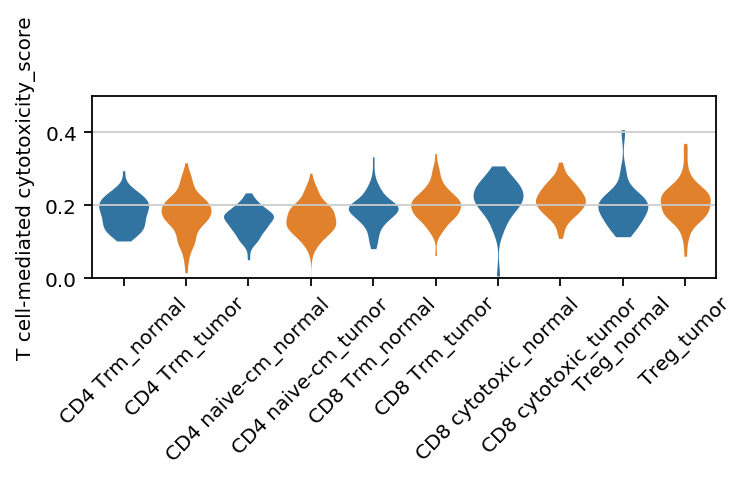

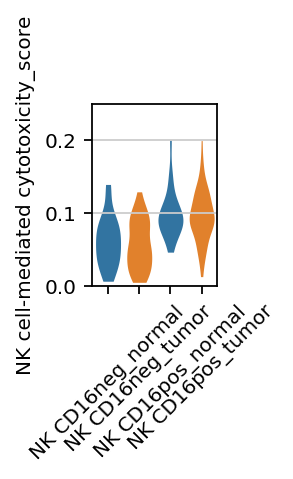

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(5,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(adata[~adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg', 'B cell'])], ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity.pdf')
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune_group', size = 0, standard_scale = 'var', swap_axes = True, palette = adata.uns['group_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity.pdf')

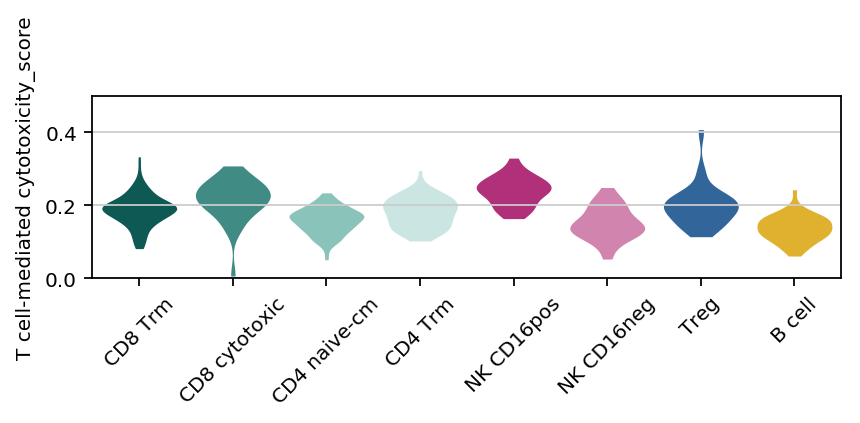

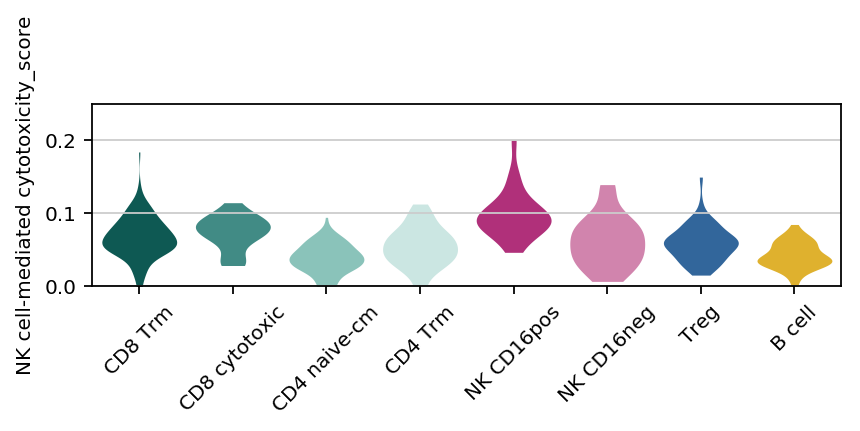

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(6,1.5))
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(ndata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_normal.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(ndata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_normal.pdf')

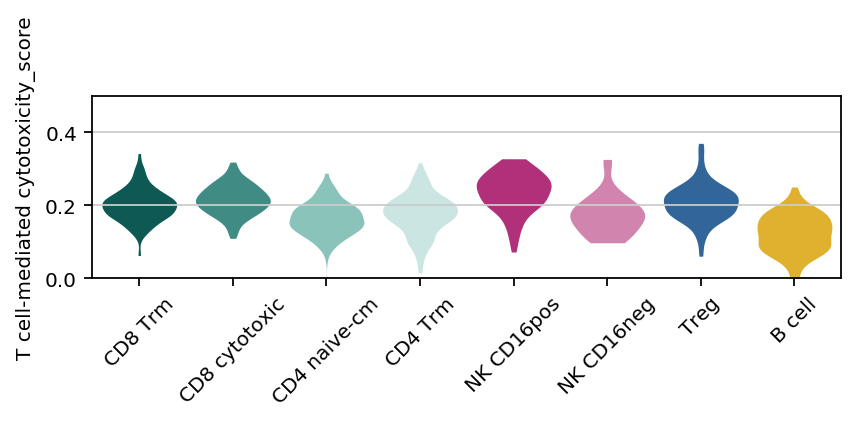

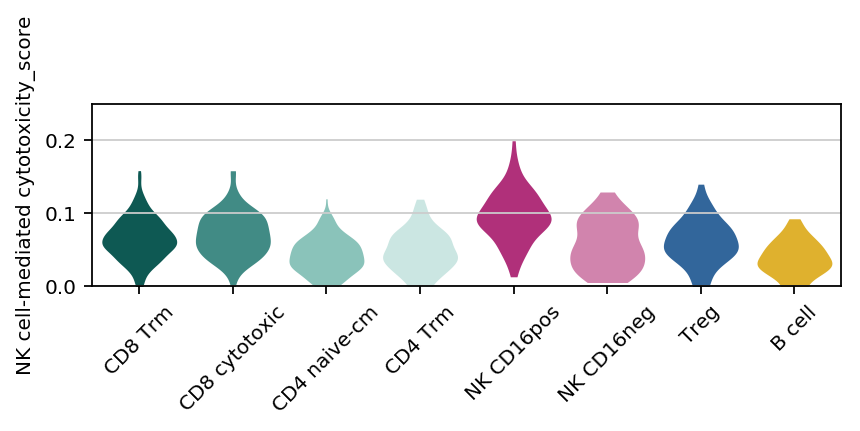

In [71]:
plt.ylim(0,.5)
ax = sns.violinplot()
sc.pl.violin(tdata, ['T cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/Tcell_cytotoxicity_tumor.pdf')
plt.ylim(0,.25)
ax = sns.violinplot()
sc.pl.violin(tdata, ['NK cell-mediated cytotoxicity_score'], groupby = 'celltype-immune', size = 0, standard_scale = 'var', swap_axes = True, palette = ndata.uns['celltype-immune_colors'], linewidth = 0, ax = ax, rotation = 45, save = '/NKcell_cytotoxicity_tumor.pdf')

computing score 'K562_score'
    finished: added
    'K562_score', score of gene set (adata.obs) (0:00:00)
computing score 'ADCC_score'
    finished: added
    'ADCC_score', score of gene set (adata.obs) (0:00:00)
computing score 'cytokine_score'
    finished: added
    'cytokine_score', score of gene set (adata.obs) (0:00:00)
computing score 'common_score'
    finished: added
    'common_score', score of gene set (adata.obs) (0:00:00)


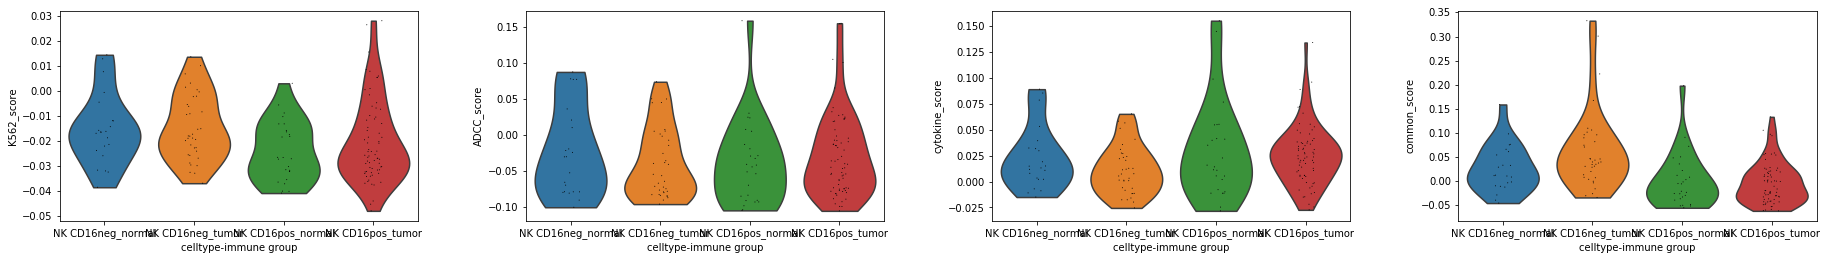

In [47]:
NKstim = {
    'K562':['ACSM3', 'ALDH1A2', 'ANLN', 'ANXA2', 'APOC1', 'ATP6V0A1', 'BCAT1', 'BUB1', 'CA8', 'CASC5', 'CCL22', 'CCNA2', 'CCNB1', 'CCNB2', 'CD86', 'CDC42BPA', 'CDC45', 'CDC6', 'CDK1', 'CENPN', 'CENPW', 'CFH', 'CKS1B', 'CKS2', 'CLIC2', 'CLIC4', 'CPED1', 'CYP51A1', 'DLGAP5', 'DSCR8', 'DSG2', 'DTL', 'EXO1', 'FAM72D', 'FN1', 'FOS', 'FOSB', 'GAGE1', 'GAGE10', 'GAGE12C', 'GAGE12F', 'GAGE12J', 'GAGE13', 'GAGE2A', 'GAGE2B', 'GAGE2D', 'GAGE2E', 'GAGE8', 'GALNT5', 'GRASP', 'GTSF1', 'GYPA', 'GYPE', 'HEMGN', 'HIST1H2AI', 'HIST1H3A', 'HIST1H3B', 'HIST1H3H', 'HMGCS1', 'HMMR', 'HSPA4L', 'IFI30', 'IL1B', 'INSIG1', 'KIAA0101', 'KIF14', 'KIF18A', 'LAPTM4B', 'LINC00515', 'MAGEC2', 'MAP1B', 'MLF1', 'MND1', 'MNS1', 'MPP1', 'MYL4', 'NCAPG', 'NDC80', 'NEK2', 'NET1', 'NMU', 'NR4A1', 'NR4A2', 'NUF2', 'NUSAP1', 'ORC1', 'PAGE1', 'PAGE2B', 'PAGE5', 'PAICS', 'PBK', 'PPA1', 'PRAME', 'PRC1', 'PRDX1', 'PRKAR2B', 'PRR11', 'PTTG1', 'RGS16', 'RHAG', 'RHOXF2B', 'RHOXF2B', 'SCG3', 'SGOL1', 'SLC27A2', 'SLC7A11', 'SQLE', 'SSX1', 'SSX2B', 'SSX2B', 'STIL', 'TFPI', 'TMEM88', 'TUBA1B', 'TXN', 'TYMS', 'UBE2T', 'VIM', 'ZNF280A'],
    'ADCC':['BCL2','GBE1','GPI','GPR18','GTSF1','HIST1H3B','IGF2R','OSBPL3','SNORD12C','TPI1','TSPAN7'],
    'cytokine':['AGK','AHR','ARHGAP31','ATP8B4','B4GALT5','BATF','C4orf32','CCND2','CCR1','CD274','CD44','CD97','CDK6','CMAHP','DDX21','DENND4A','FURIN','GADD45B','GZMB','HAPLN3','HAVCR2','HK2','HUWE1','ICAM1','IFNG','IL12RB2','IL18R1','IL26','IL4R','IRF8','ITGA1','KCNA3','KIF3B','LINC00515','MAML2','MAP3K8','MDFIC','METTL1','MFSD2A','MIR147B','MIR4772','MT2A','MTHFD2','NABP1','NDFIP2','NFAT5','NFKB1','NFKBIA','P2RX5','PIM1','PIM2','PUS7','RCN1P2','RGS16','RNU12','SLAMF7','SLC27A2','SLC7A5','SMS','SNORD1A','SOCS2','SOD2','TMEM88','TNFAIP8'],
    'common':[ 'BCL2A1', 'CCL3', 'CCL3L3', 'CCL3L1', 'CCL3L3', 'CCR7', 'CD83', 'CRTAM', 'CSF2', 'CXCL9', 'EGR2', 'HILPDA', 'IL21R', 'IL2RA', 'IRF4', 'KDM6B', 'LYZ', 'MIR155', 'NR4A3', 'SDC4', 'STARD4', 'TNFRSF9', 'TRAF1', 'XCL1', 'XCL2']}
for gs in NKstim:
    sc.tl.score_genes(adata, NKstim[gs], score_name = str(gs)+'_score', use_raw=True)
sc.pl.violin(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], [str(gs)+'_score' for gs in NKstim], groupby = 'celltype-immune_group')

Trying to set attribute `.obs` of view, making a copy.
... storing 'celltype-immune_group' as categorical


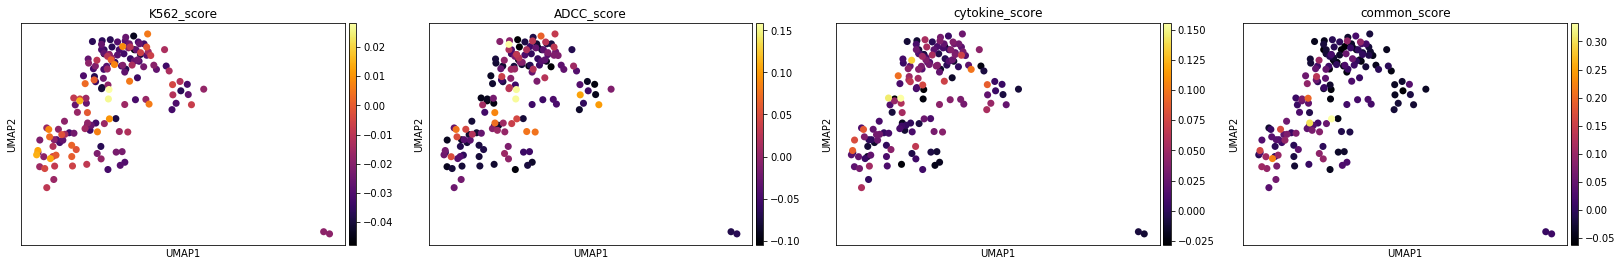

In [27]:
sc.pl.umap(adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])], color = [str(gs)+'_score' for gs in NKstim], color_map = 'inferno', size = 200)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.5


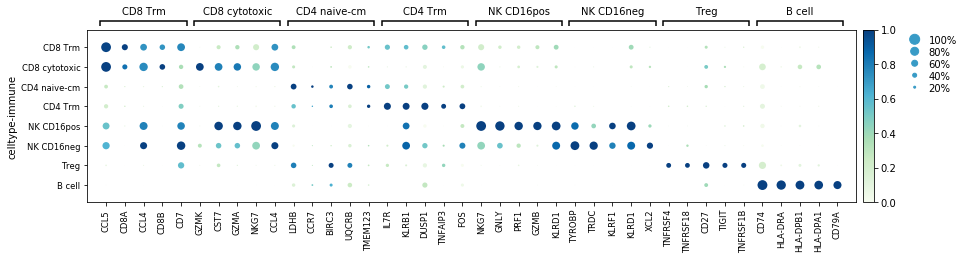

In [2]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype-immune', method = 'wilcoxon', n_genes=30000)
sc.tl.filter_rank_genes_groups(adata, min_fold_change=1)
sc.pl.rank_genes_groups_dotplot(adata, 
                                key='rank_genes_groups_filtered', 
                                n_genes = 5, 
                                standard_scale = 'var', 
                                dendrogram=False,
                                color_map = 'GnBu', 
                                var_group_rotation = 0,
                                save = '/lymphoid_rank_gene_dotplot.pdf')

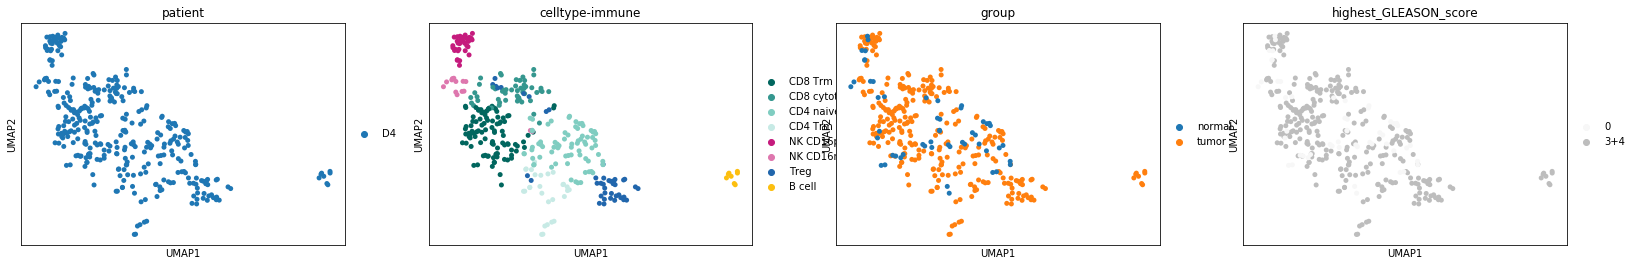

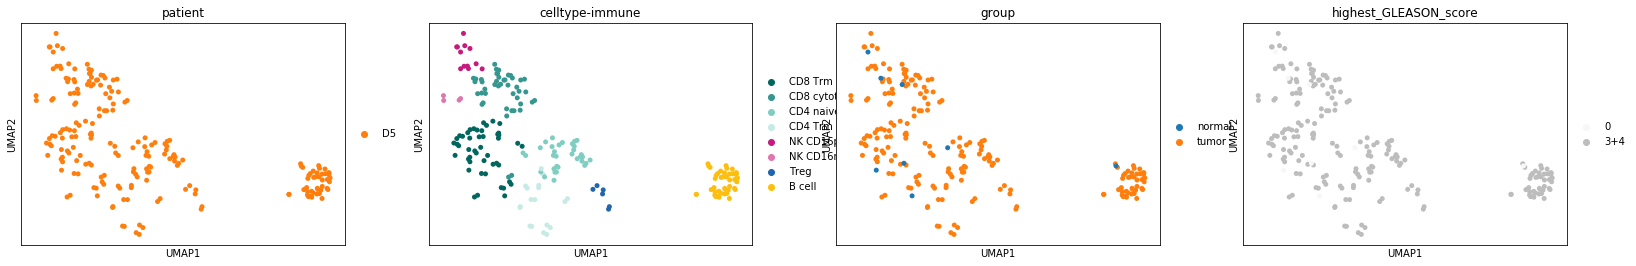

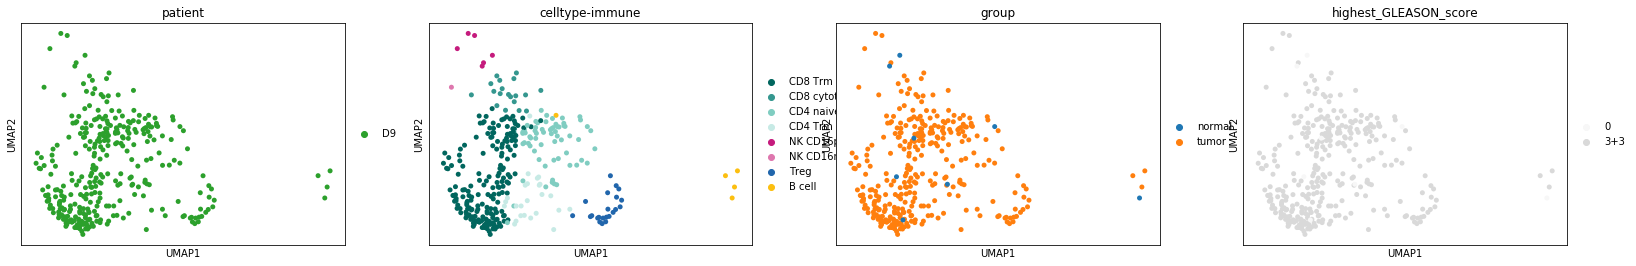

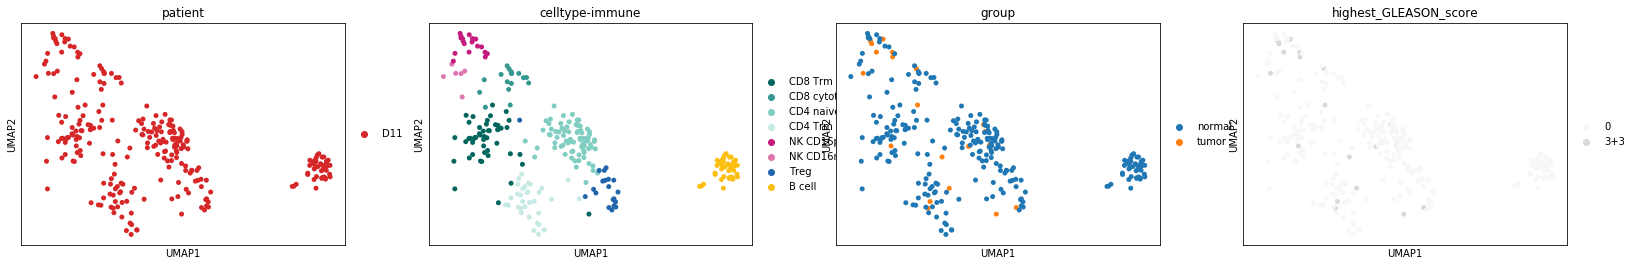

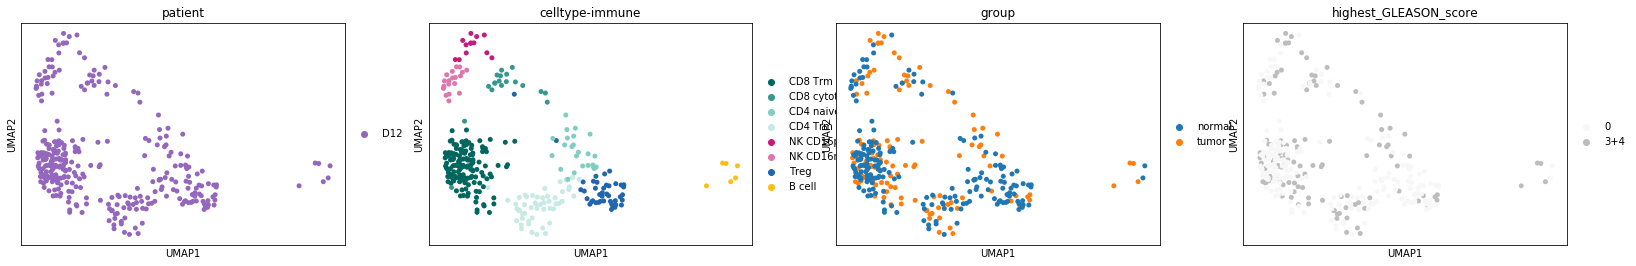

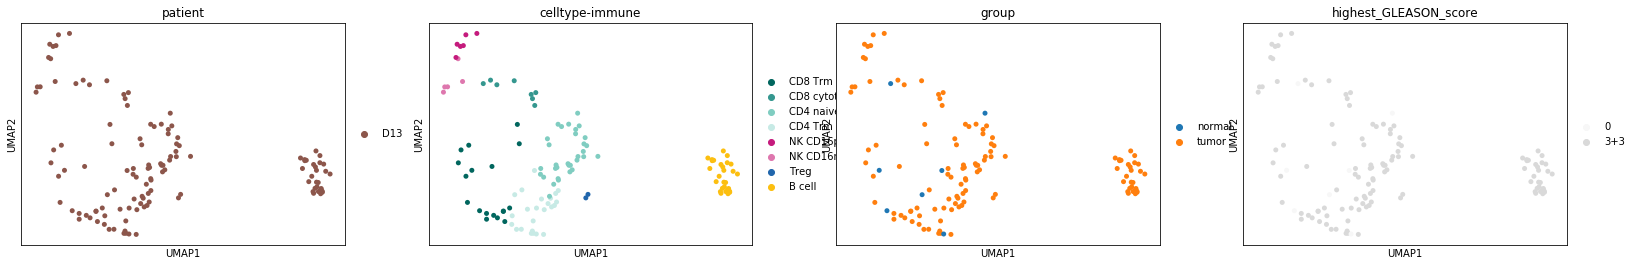

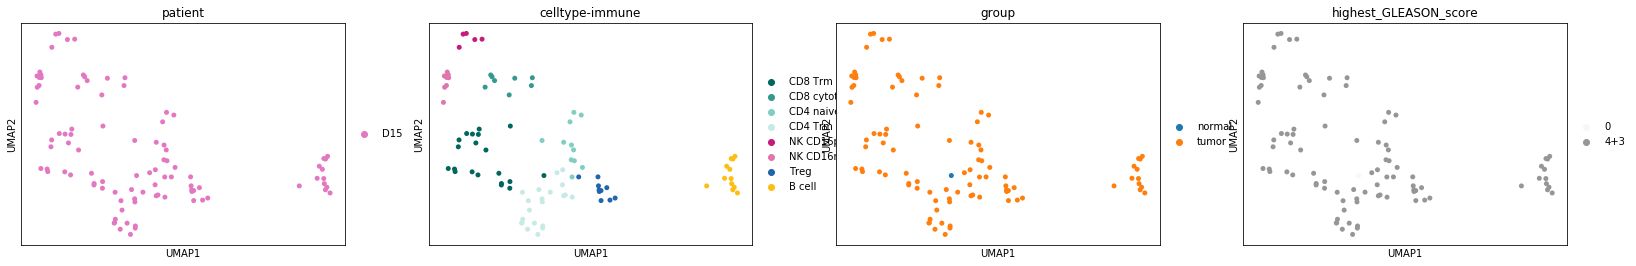

In [46]:
for p in ['D4', 'D5', 'D9', 'D11', 'D12', 'D13', 'D15']:
    sc.pl.umap(adata[adata.obs['patient']==p], color = ['patient', 'celltype-immune', 'group', 'highest_GLEASON_score'], size = 100)

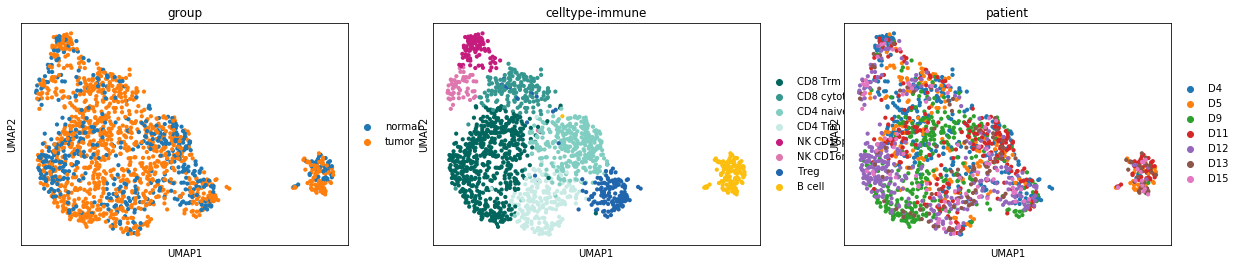

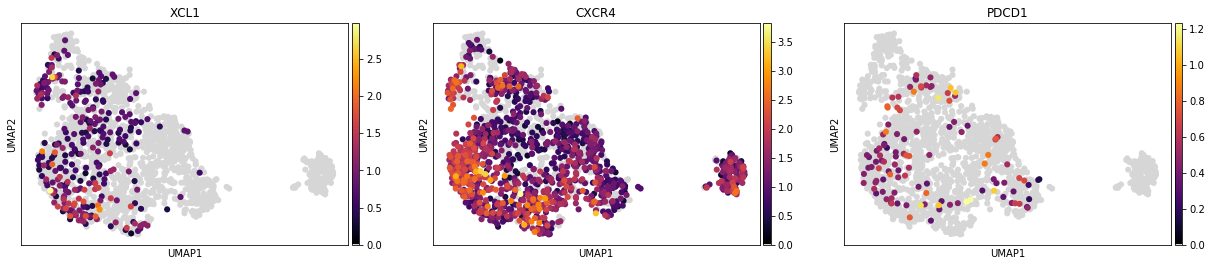

In [48]:
sc.pl.umap(adata, color = ['group','celltype-immune','patient'], color_map = newcmp)
sc.pl.umap(adata, color = ['XCL1','CXCR4', 'PDCD1'], color_map = newcmp, size = 150)

In [3]:
# save
results_file = 'out/lymphoid.h5ad'
# save this file
adata.write(results_file, compression = 'gzip')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

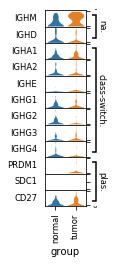

In [2]:
bdata = adata[adata.obs['celltype'] == 'B cell']
sc.pl.stacked_violin(bdata, 
              {'naive':['IGHM', 'IGHD'], 
               'class-switched':['IGHA1', 'IGHA2', 'IGHE', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'],
               'plasma cell':['PRDM1', 'SDC1', 'CD27']},
              groupby = 'group',
              standard_scale = 'var',
              swap_axes = True,
              color_map = 'viridis',
              var_group_rotation = 0,
              linewidth = 0,
              save = '/immunogobulins_Bcell normal tumor.pdf',
              palette = bdata.uns['group_colors'])

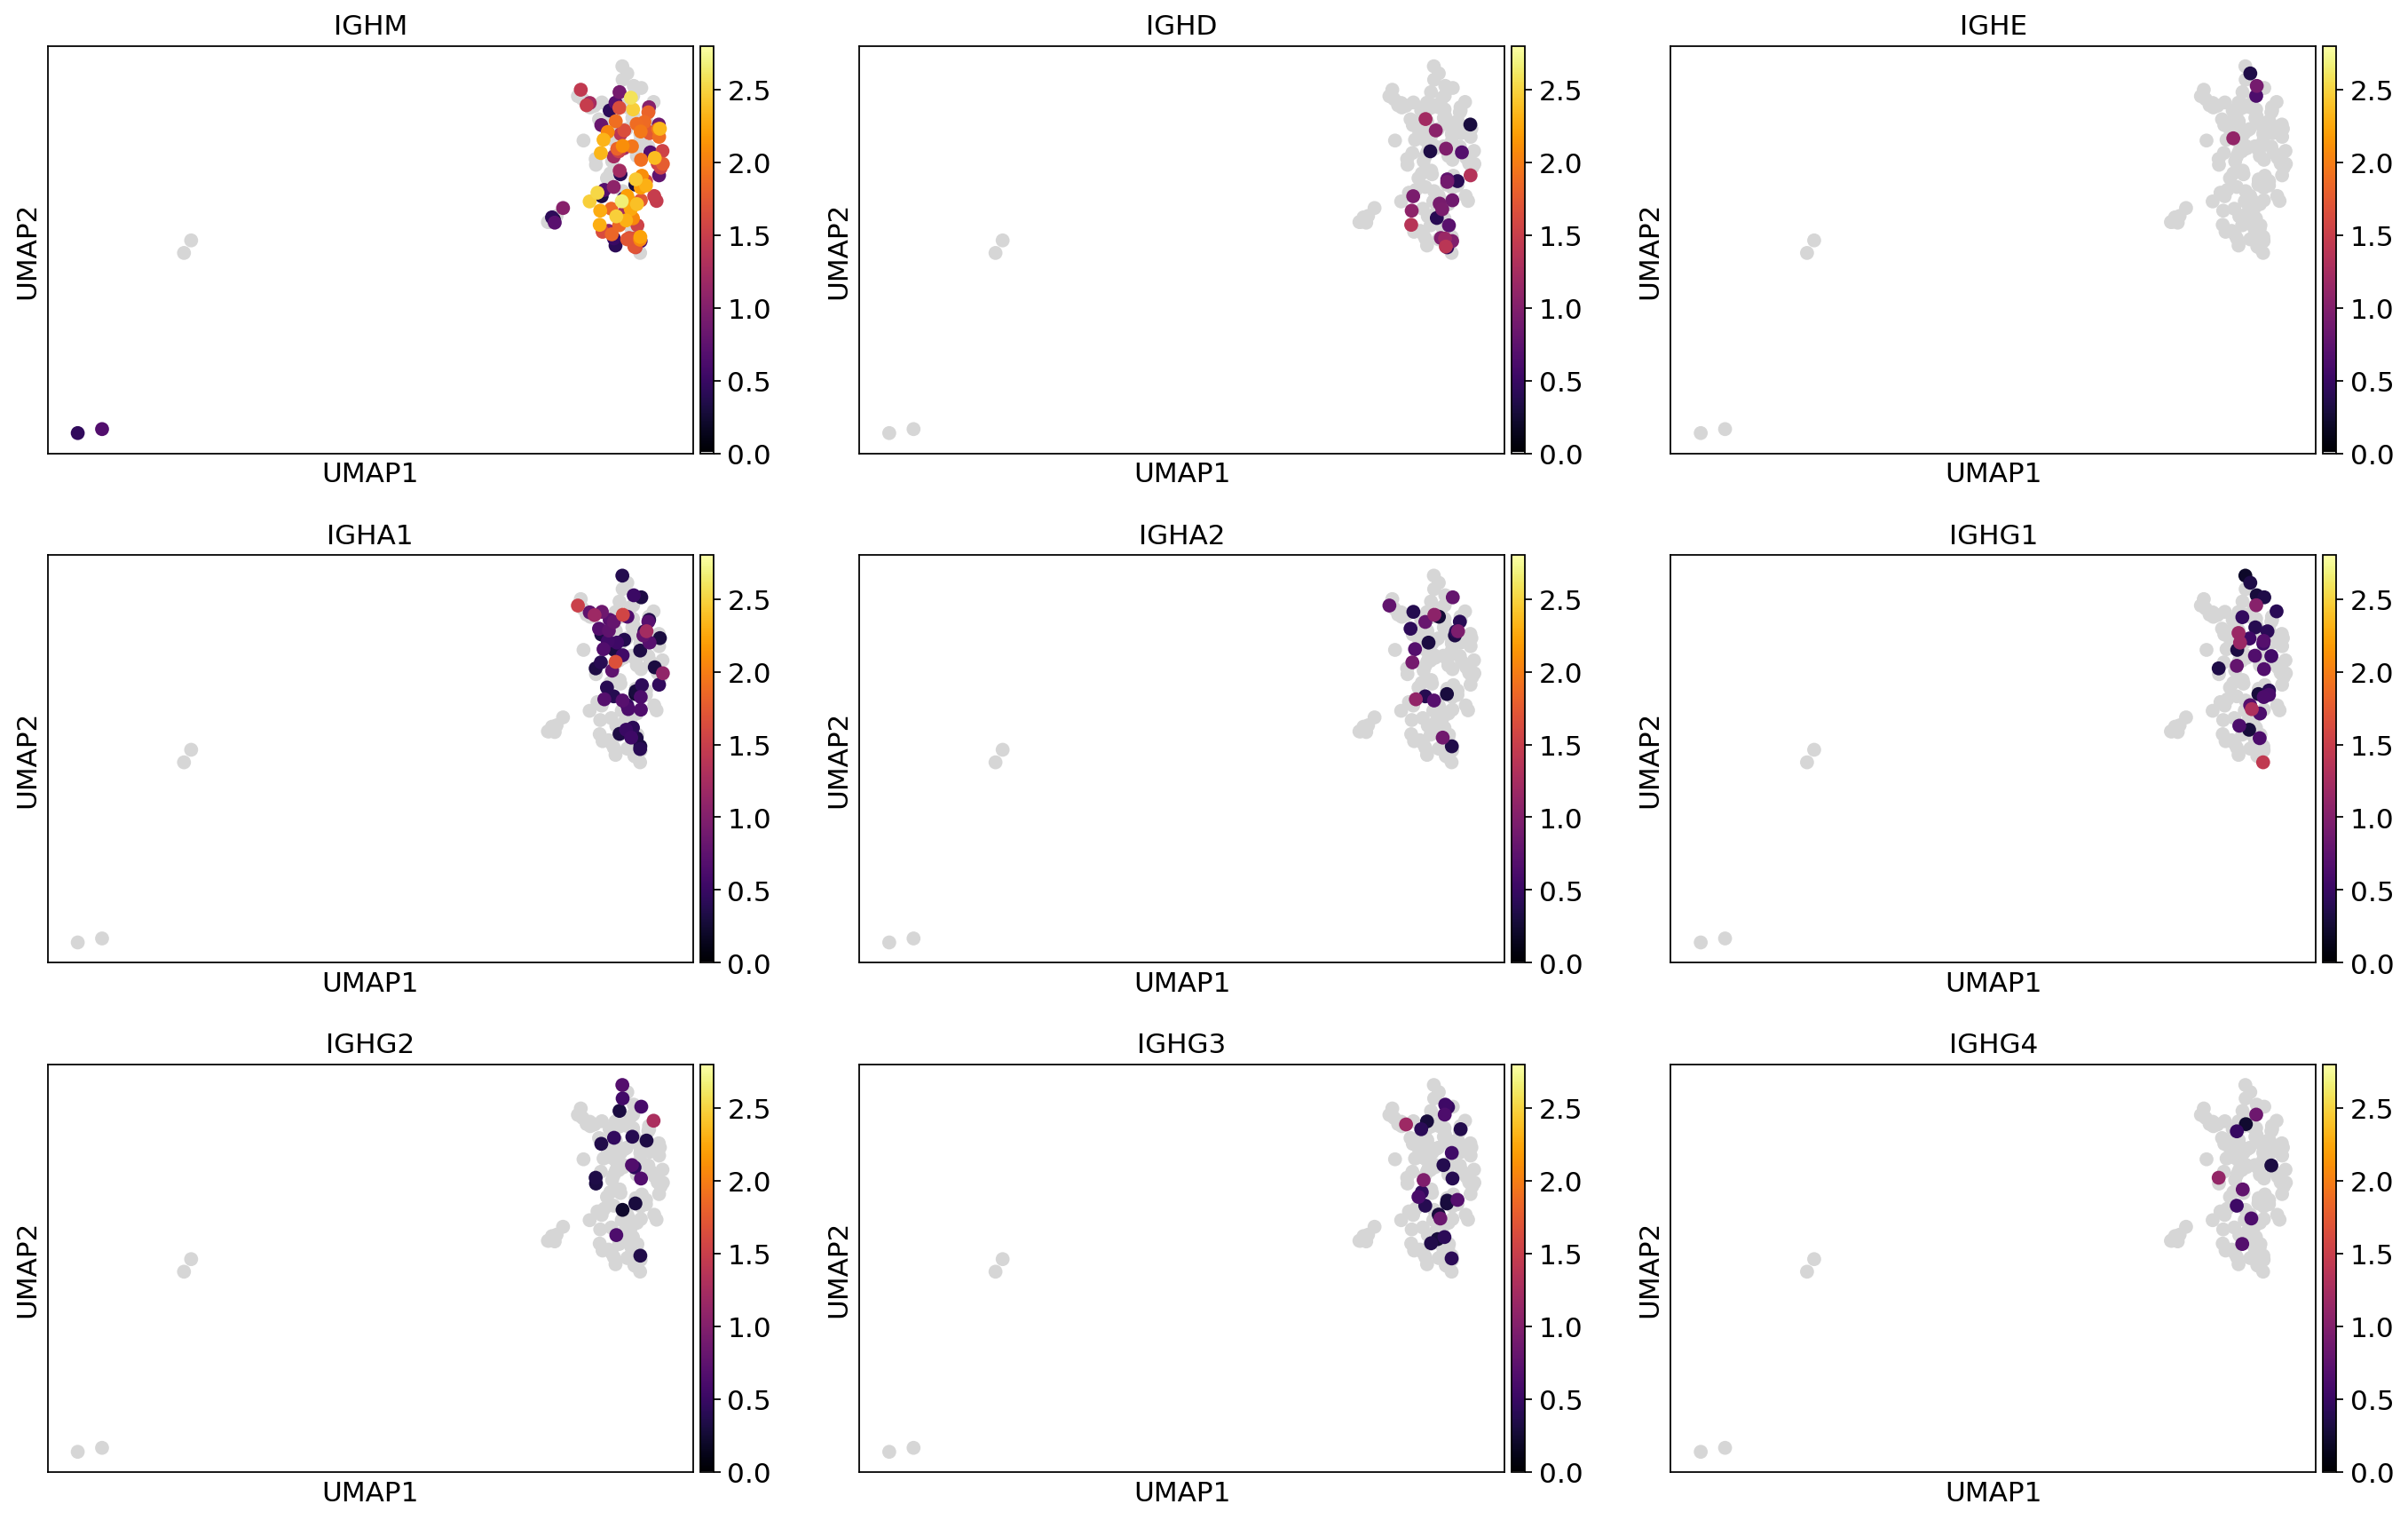

In [8]:
bdata = adata[adata.obs['celltype'] == 'B cell']
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(bdata, color = ['IGHM', 'IGHD', 'IGHE', 'IGHA1', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell ImmunoGobulins.pdf')

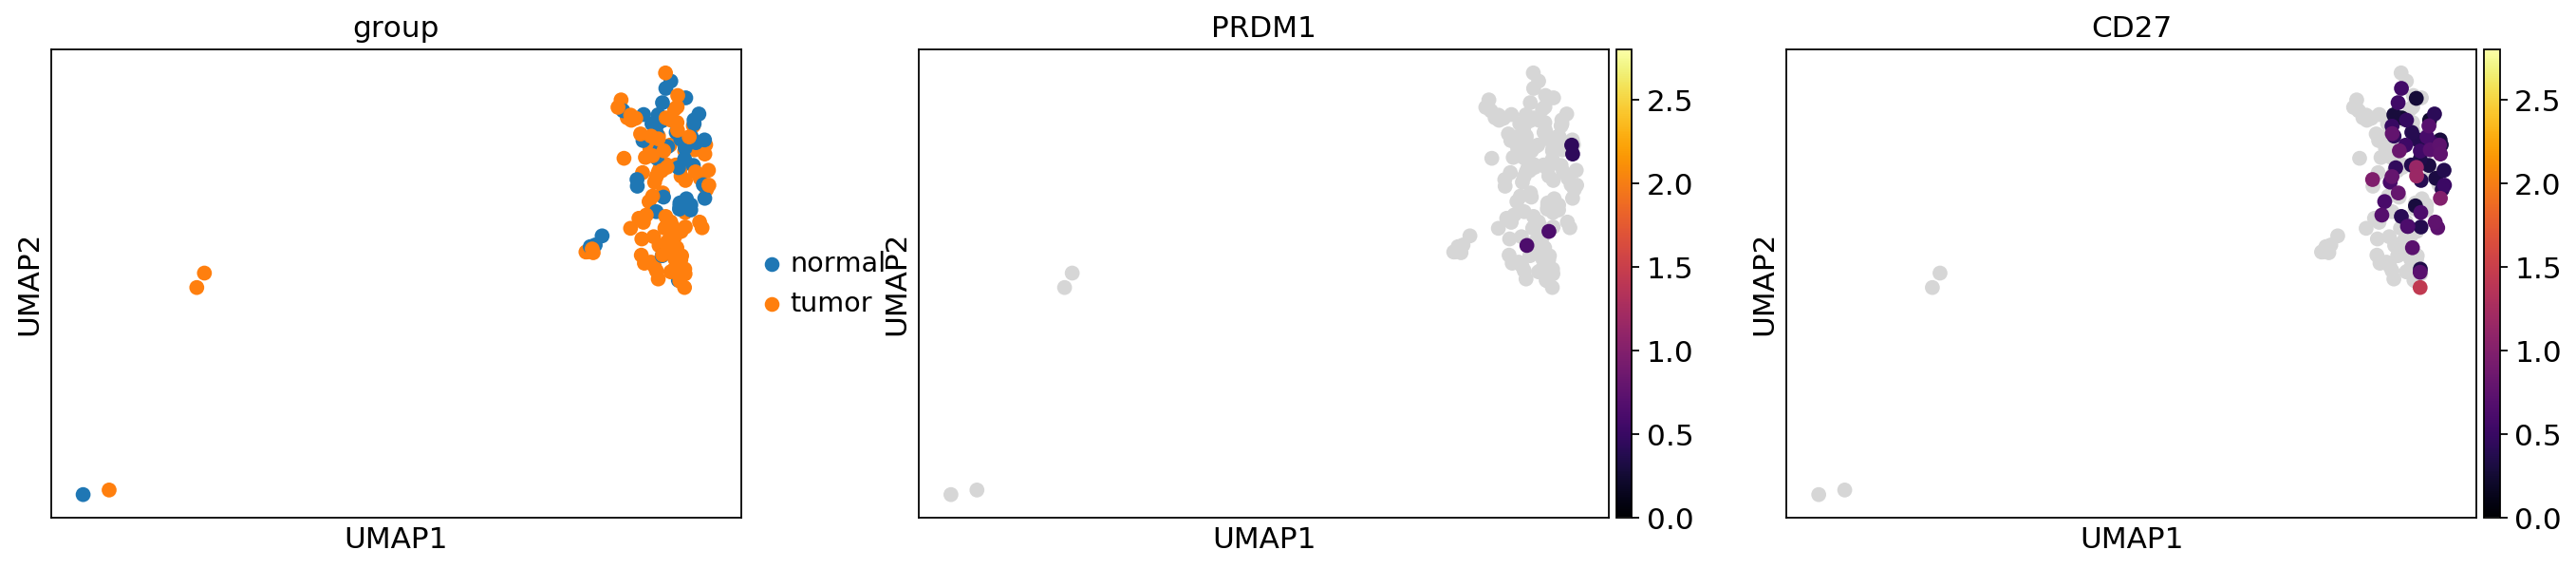

In [9]:
sc.pl.umap(bdata, color = ['group', 'PRDM1', 'CD27'], ncols = 3, vmax = 2.8, color_map = newcmp, size = 200, save = '/Bcell plasma.pdf')

In [14]:
module = ['MARCH1', 'MARCH8', 'ABCB9', 'ACE', 'ACTR10', 'ACTR1A', 'ACTR1B', 'AP1B1', 'AP1G1', 'AP1M1', 'AP1M2', 'AP1S1', 'AP1S2', 'AP1S3', 'AP2A1', 'AP2A2', 'AP2B1', 'AP2M1', 'AP2S1', 'AP3B1', 'AP3D1', 'ARF1', 'ATG5', 'AZGP1', 'B2M', 'BCAP31', 'CALR', 'CANX', 'CAPZA1', 'CAPZA2', 'CAPZA3', 'CAPZB', 'CCL19', 'CCL21', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD207', 'CD209', 'CD36', 'CD68', 'CD74', 'CD8A', 'CENPE', 'CHUK', 'CLEC4A', 'CLEC4M', 'CLTA', 'CLTC', 'CTSD', 'CTSE', 'CTSF', 'CTSH', 'CTSL', 'CTSS', 'CTSV', 'CYBA', 'CYBB', 'DCTN1', 'DCTN2', 'DCTN3', 'DCTN4', 'DCTN5', 'DCTN6', 'DNM2', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNLL1', 'DYNLL2', 'E7ENX8', 'ERAP1', 'ERAP2', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FCGR2B', 'FCGRT', 'FGL2', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'ICAM1', 'IDE', 'IFI30', 'IKBKB', 'IKBKG', 'ITGAV', 'ITGB5', 'KIF11', 'KIF15', 'KIF18A', 'KIF22', 'KIF23', 'KIF26A', 'KIF2A', 'KIF2B', 'KIF2C', 'KIF3A', 'KIF3B', 'KIF3C', 'KIF4A', 'KIF4B', 'KIF5A', 'KIFAP3', 'KLC1', 'KLC2', 'LAG3', 'LGMN', 'LILRB2', 'LNPEP', 'MICA', 'MICB', 'MR1', 'NCF1', 'NCF2', 'NCF4', 'NOD1', 'NOD2', 'OSBPL1A', 'PDIA3', 'PSAP', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'PYCARD', 'RAB10', 'RAB27A', 'RAB32', 'RAB33A', 'RAB34', 'RAB35', 'RAB3B', 'RAB3C', 'RAB4A', 'RAB5B', 'RAB6A', 'RAB7A', 'RAB8B', 'RACGAP1', 'RELB', 'RFTN1', 'RILP', 'SAR1B', 'SEC13', 'SEC22B', 'SEC23A', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SH3GL2', 'SLC11A1', 'SNAP23', 'SPTBN2', 'TAP1', 'TAP2', 'TAPBP', 'TAPBPL', 'THBS1', 'TRAF6', 'TREM2', 'TREX1', 'VAMP3', 'VAMP8', 'WAS', 'YTHDF1']
sc.tl.score_genes(bdata, module, score_name = 'Antigen processing and presentation_score', use_raw=True)

computing score 'Antigen processing and presentation_score'
    finished: added
    'Antigen processing and presentation_score', score of gene set (adata.obs) (0:00:00)


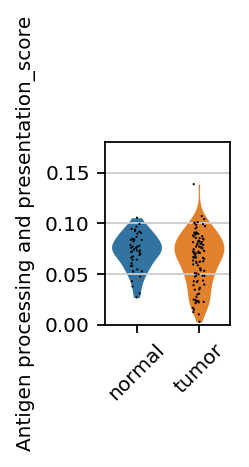

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
ax = sns.violinplot()
sc.pl.violin(bdata, ['Antigen processing and presentation_score'], ax = ax, groupby = 'group', size = 1, standard_scale = 'var', linewidth = 0, rotation = 45, save = '/B cell_Antigen processing and presentation_score.pdf')
bdata.obs[['group','Antigen processing and presentation_score']].to_csv('figures/violin/Antigen processing and presentation_score.csv')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata
# try gene set test with Wherry exhaustion genesets
genesets = pd.read_csv('dataset/Mouse_exhaustion_genesets_converted.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(adata, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0
computing score 'GSE41867 Chronic-acute CD8+ Up_score'
    finished: added
    'GSE41867 Chronic-acute CD8+ Up_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE41870 CD8+ LCMV Chronic-Acute UP_score'
    finished: added
    'GSE41870 CD8+ LCMV Chronic-Acute UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score'
    finished: added
    'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', score of gene set (adata.obs) (0:00:00)


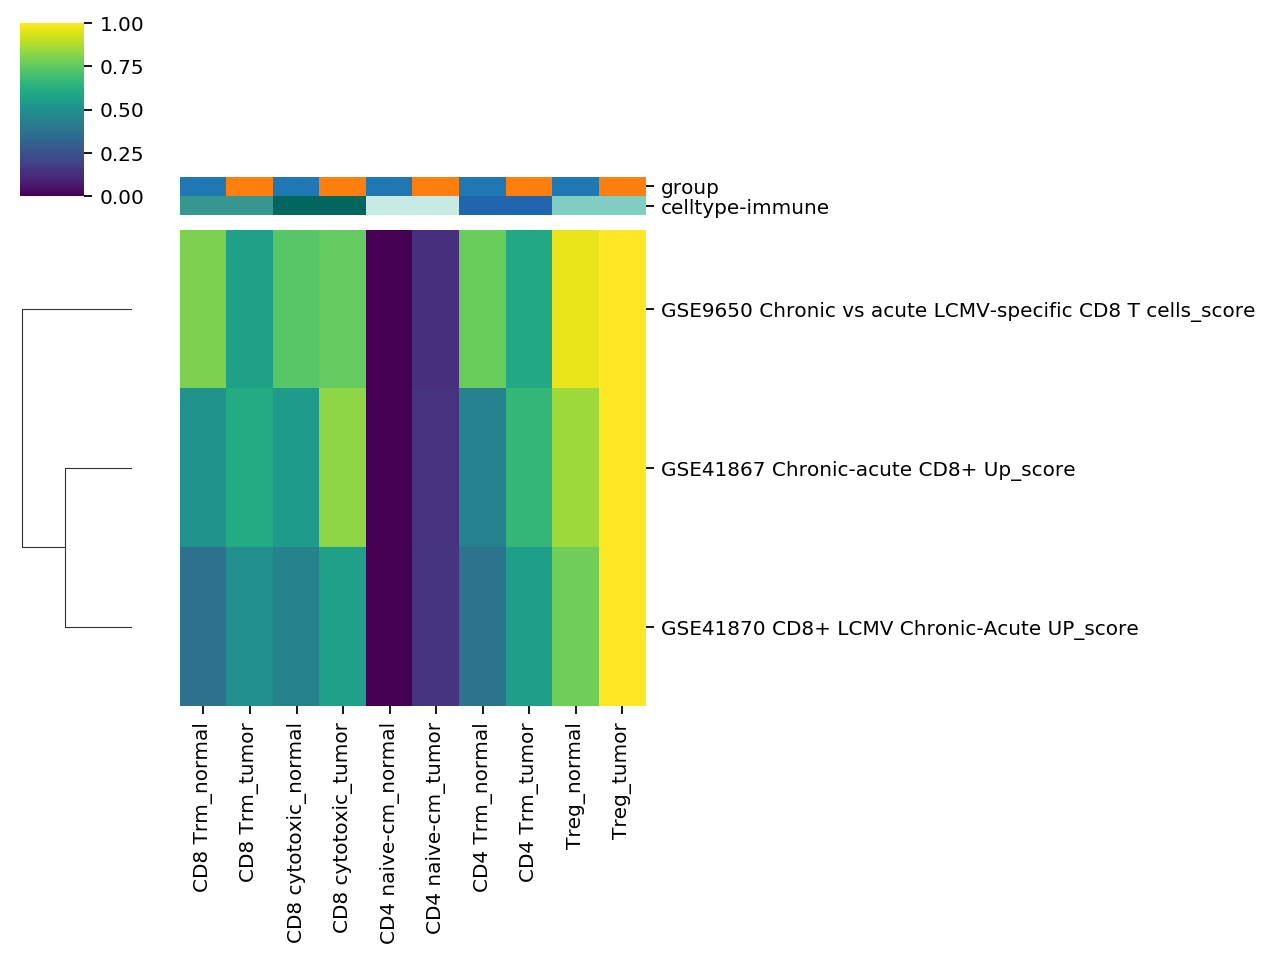

In [52]:
adata = adata[~adata.obs['leiden'].isin(['2,0','2,1', '4'])]
# calculate average enrichment score
list1 = list(set(adata.obs['celltype-immune']))
subset = adata.obs[['group', 'celltype-immune'] + [str(m)+'_score' for m in genesets.columns]]
outputN = pd.DataFrame()
outputT = pd.DataFrame()
for x in list1:
    subsetN = subset[(subset.group == 'normal') & (subset['celltype-immune'] == x)]
    subsetT = subset[(subset.group == 'tumor') & (subset['celltype-immune'] == x)]
    outdictN = {}
    outdictT = {}
    for k in [str(m)+'_score' for m in genesets.columns]:
        outN = {k:np.mean(subsetN[k])}
        outT = {k:np.mean(subsetT[k])}
        outdictN.update(outN)
        outdictT.update(outT)
    outputN = outputN.append(outdictN, ignore_index=True)
    outputT = outputT.append(outdictT, ignore_index=True)
outputN.index = [l+'_normal' for l in list1]
outputT.index = [l+'_tumor' for l in list1]

output = pd.concat([outputN, outputT])

import itertools
col_colors1 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(itertools.chain.from_iterable(itertools.repeat(x, len(list1)) for x in adata.uns['group_colors']))))))
col_colors2 = pd.Series(output.index.map(dict(zip([l + '_normal' for l in list1] + [l + '_tumor' for l in list1], list(list(adata.uns['celltype-immune_colors']) + list(adata.uns['celltype-immune_colors']))))))
col_colors = pd.concat([col_colors1, col_colors2],axis=1)
col_colors.index = [l + '_normal' for l in list1] + [l + '_tumor' for l in list1]
col_colors.columns = ['group', 'celltype-immune']

output = output.transpose()

import matplotlib.pyplot as plt
g = sns.clustermap(output[['CD8 Trm_normal', 'CD8 Trm_tumor', 'CD8 cytotoxic_normal', 'CD8 cytotoxic_tumor', 'CD4 naive-cm_normal', 'CD4 naive-cm_tumor', 'CD4 Trm_normal', 'CD4 Trm_tumor', 'Treg_normal', 'Treg_tumor']], col_colors = col_colors, col_cluster=False, standard_scale = 0, cmap="viridis", figsize=(8, 6))
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

if not os.path.exists('figures/heatmap/'):
    os.makedirs('figures/heatmap/')
g.savefig('figures/heatmap/Wherry_ex_geneset_score_split.pdf')

In [58]:
output

CD8 cytotoxic_normal  \
GSE41867 Chronic-acute CD8+ Up_score                           -0.014311   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                      -0.016991   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...              0.009832   

                                                    CD8 Trm_normal  \
GSE41867 Chronic-acute CD8+ Up_score                     -0.014596   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                -0.017764   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...        0.011106   

                                                    Treg_normal  \
GSE41867 Chronic-acute CD8+ Up_score                  -0.011346   
GSE41870 CD8+ LCMV Chronic-Acute UP_score             -0.013641   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...     0.014348   

                                                    CD4 naive-cm_normal  \
GSE41867 Chronic-acute CD8+ Up_score                          -0.019496   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                     -0.021457   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...            -0.004585   

                                                    CD4 Trm_normal  \
GSE41867 Chronic-acute CD8+ Up_score                     -0.015294   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                -0.017643   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...        0.010537   

                                                    CD8 cytotoxic_tumor  \
GSE41867 Chronic-acute CD8+ Up_score                          -0.011601   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                     -0.015821   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...             0.010283   

                                                    CD8 Trm_tumor  Treg_tumor  \
GSE41867 Chronic-acute CD8+ Up_score                    -0.013681   -0.009968   
GSE41870 CD8+ LCMV Chronic-Acute UP_score               -0.016456   -0.011449   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...       0.006611    0.015005   

                                                    CD4 naive-cm_tumor  \
GSE41867 Chronic-acute CD8+ Up_score                         -0.018130   
GSE41870 CD8+ LCMV Chronic-Acute UP_score                    -0.019924   
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...           -0.001975   

                                                    CD4 Trm_tumor  
GSE41867 Chronic-acute CD8+ Up_score                    -0.013202  
GSE41870 CD8+ LCMV Chronic-Acute UP_score               -0.015898  
GSE9650 Chronic vs acute LCMV-specific CD8 T ce...       0.007125

In [38]:
cd8t1 = adata[adata.obs['celltype-immune'].isin(['CD8 Trm', 'CD8 cytotoxic'])]
cd8t2 = adata[adata.obs['celltype-immune'].isin(['CD4 naive-cm', 'CD4 Trm', 'Treg'])]

In [39]:
cd8t1.obs['celltype-immune_group'] = [c +'_' +g for c,g in zip(cd8t1.obs['celltype-immune'], cd8t1.obs['group'])]
cd8t2.obs['celltype-immune_group'] = [c +'_' +g for c,g in zip(cd8t2.obs['celltype-immune'], cd8t2.obs['group'])]

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


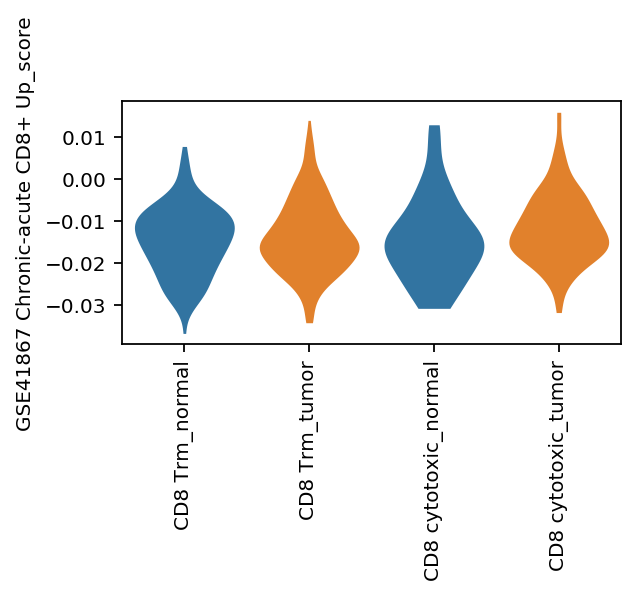

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(4,2))
ax = sns.violinplot()
ax.grid(False)
sc.pl.violin(cd8t1, ['GSE41867 Chronic-acute CD8+ Up_score'], groupby = 'celltype-immune_group', palette = cd8t.uns['group_colors'], linewidth = 0, size = 0, rotation = 90, ax = ax, save = '/CD8T_violin_exhaustion.pdf')

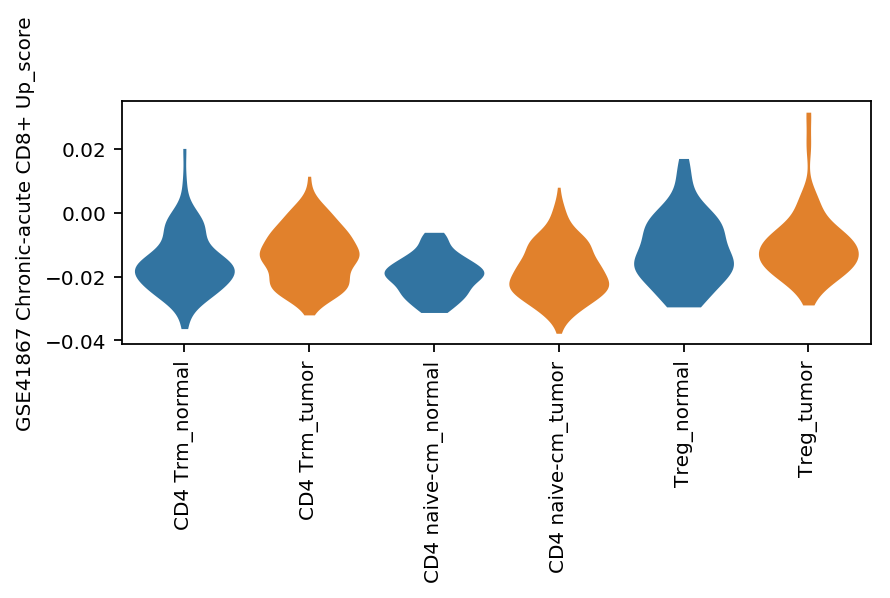

In [48]:
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(6,2))
ax = sns.violinplot()
ax.grid(False)
sc.pl.violin(cd8t2, ['GSE41867 Chronic-acute CD8+ Up_score'], groupby = 'celltype-immune_group', palette = cd8t2.uns['group_colors'], linewidth = 0, size = 0, rotation = 90, ax = ax, )

In [24]:
from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests
def geneset_ranksums(self, keys, column, groups, fdr = True):
    keys = list(keys)
    x = self.obs[self.obs[column] == groups[0]]
    y = self.obs[self.obs[column] == groups[1]]
    stats = []
    pvals = []
    for key in keys:
#         res = ranksums(x[key], y[key])
        res = mannwhitneyu(x[key], y[key])
        stats.append(res.statistic)
        pvals.append(res.pvalue)
    df = pd.DataFrame(zip(stats, pvals), columns = ['statistic', 'pvals'], index = keys)
    if fdr:
        df['bh_pvals'] = multipletests(df['pvals'], method = 'fdr_bh')[1]
        df['significant'] = df['bh_pvals'] < 0.05
    else:
        df['significant'] = df['pvals'] < 0.05
    return(df)

In [13]:
from collections import defaultdict
dat = defaultdict(dict)

In [14]:
for i in list(set(cd8t.obs['celltype-immune'])):
    dat[i] = cd8t[cd8t.obs['celltype-immune'] == i].copy()

In [ ]:
cd8t = adata[adata.obs['celltype-immune'].isin(['CD8 Trm', 'CD8 cytotoxic', 'CD4 naive-cm', 'CD4 Trm', 'Treg'])]

In [35]:
res = pd.DataFrame()
for i in list(set(cd8t.obs['celltype-immune'])):
    res = res.append(geneset_ranksums(dat[i], ['GSE41867 Chronic-acute CD8+ Up_score'], 'group', ('tumor', 'normal')))
res.index = list(set(cd8t.obs['celltype-immune']))
res['bh_pvals'] = multipletests(res['pvals'], method = 'fdr_bh')[1]
res['significant'] = res['bh_pvals'] < 0.05

In [36]:
res

statistic     pvals  bh_pvals  significant
CD4 Trm           3895.0  0.028496  0.112885        False
CD4 naive-cm     10742.0  0.155480  0.259133        False
Treg              2333.0  0.270909  0.305907        False
CD8 Trm          31554.0  0.305907  0.305907        False
CD8 cytotoxic     1696.0  0.045154  0.112885        False

In [32]:
res

statistic     pvals  bh_pvals  significant
CD4 Trm           3895.0  0.028496  0.028496         True
CD4 naive-cm     10742.0  0.155480  0.155480        False
Treg              2333.0  0.270909  0.270909        False
CD8 Trm          31554.0  0.305907  0.305907        False
CD8 cytotoxic     1696.0  0.045154  0.045154         True

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

# transfer these slots to a raw object
adata_raw = sc.read_h5ad('out/prostate_raw.h5ad')
adata_raw = adata_raw[(adata_raw.obs['celltype'].isin(['Tcell', 'Bcell', 'NKcell'])) & ~(adata.obs['patient'].isin(['D7','D6','D14']))]
adata_raw.obs = adata.obs
adata_raw.obs['cohort'] = 'UCAM'
adata_raw.obsm = adata.obsm
adata_raw.uns = adata.uns

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
# save
adata_raw.write('out/lymphoid_raw.h5ad', compression = 'gzip')

... storing 'cohort' as categorical


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


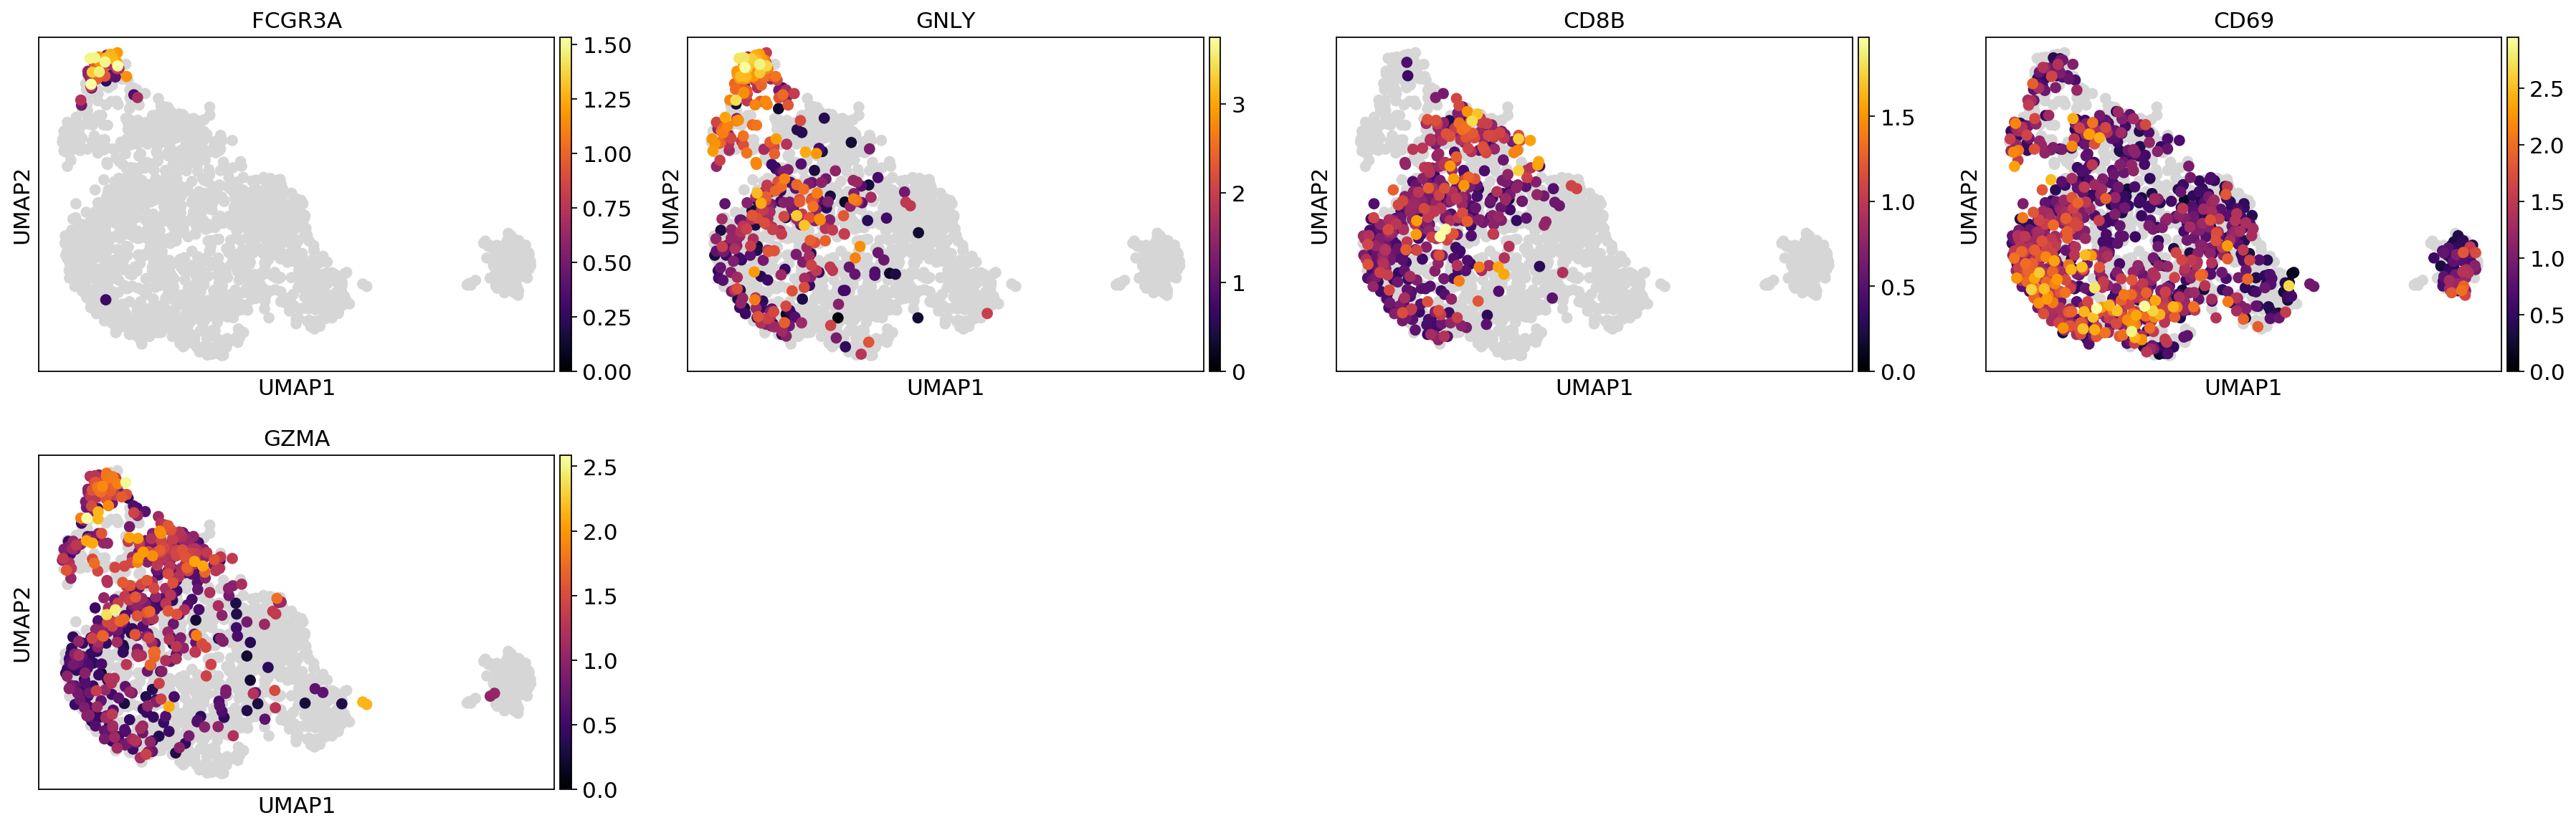

In [11]:
sc.set_figure_params(vector_friendly=True, dpi_save=900, figsize = (6,4))
sc.pl.umap(adata, color = ['FCGR3A', 'GNLY', 'CD8B', 'CD69', 'GZMA'], size =200, color_map = newcmp, save = '/lymphoid_markers.pdf')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [2]:
adata

AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

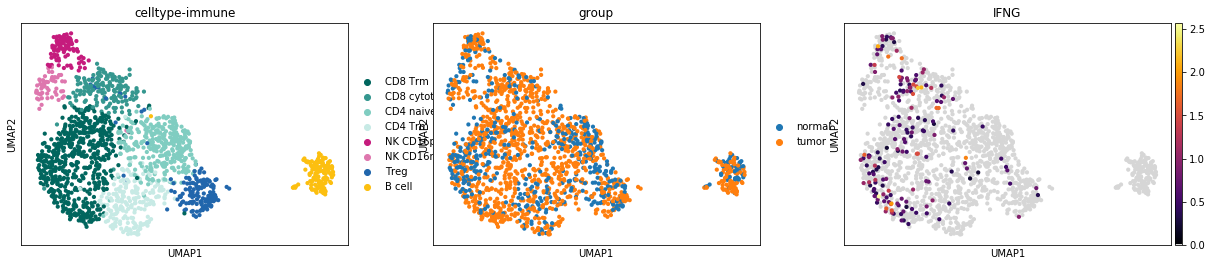

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)
sc.pl.umap(adata, color = ['celltype-immune', 'group','IFNG'], color_map = newcmp)

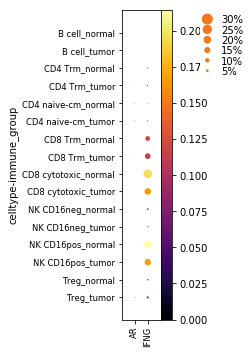

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[0.7, 0, 0.2, 0.5, 0.25])

In [3]:
sc.pl.dotplot(adata, ['AR', 'IFNG'], groupby = 'celltype-immune_group', color_map = 'inferno')

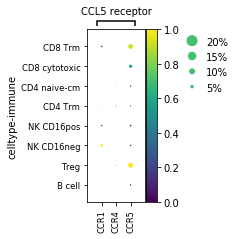

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[1.0499999999999998, 0, 0.2, 0.5, 0.25])

In [10]:
sc.pl.dotplot(adata, {'CCL5 receptor':['CCR1', 'CCR4', 'CCR5']}, groupby = 'celltype-immune', color_map = 'viridis', standard_scale = 'var', var_group_rotation = 0)

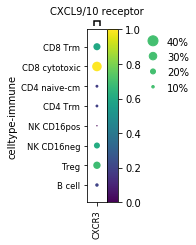

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[0.35, 0, 0.2, 0.5, 0.25])

In [3]:
sc.pl.dotplot(adata, {'CXCL9/10 receptor':['CXCR3']}, groupby = 'celltype-immune', color_map = 'viridis', standard_scale = 'var', var_group_rotation = 0, save = '/cxcr3_receptordotplot.pdf')

In [68]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [69]:
# subset to only normal
adata = adata[adata.obs['group'] == 'normal']
adata

View of AnnData object with n_obs × n_vars = 523 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

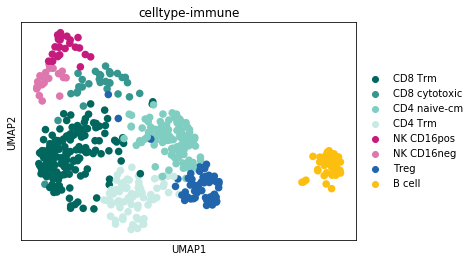

In [70]:
sc.pl.umap(adata, color = ['celltype-immune'])

In [71]:
adata.uns['celltype-immune_colors']

['#01665e',
 '#35978f',
 '#80cdc1',
 '#c7eae5',
 '#c51b7d',
 '#de77ae',
 '#2166ac',
 '#fcbf10']

In [4]:
# subset to just NK cells
adata = adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])]
adata

View of AnnData object with n_obs × n_vars = 48 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 

In [5]:
## recreate the data but trim away genes that are not expressed
adata = sc.AnnData(X = adata.raw.X, obs = adata.obs, var = adata.raw.var, uns = adata.uns, obsm = adata.obsm)

In [6]:
sc.pp.filter_genes(adata, min_cells = 3)
adata.raw = adata

filtered out 17576 genes that are detected in less than 3 cells


In [7]:
# scale the entire data
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value = 10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [8]:
sc.tl.rank_genes_groups(adata, groupby = 'celltype-immune', method = 'wilcoxon', n_genes=30000, use_raw = True, pts = True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [10]:
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import returnDEres,exportDEres

In [76]:
exportDEres(adata, key = 'rank_genes_groups', column = 'NK CD16pos', filename = 'out/DEG/NKCD16posvsneg.txt')
exportDEres(adata, key = 'rank_genes_groups', column = 'NK CD16neg', filename = 'out/DEG/NKCD16negvspos.txt')

In [17]:
dat = returnDEres(adata, key = 'rank_genes_groups', column = 'NK CD16pos')

In [54]:
filtereddat = dat[(dat['pvals'] < 0.05)]

In [55]:
filtereddat['filter'] = [(x > 0.25) | (x < -0.25) for x in filtereddat['logfoldchanges']]

In [56]:
filtereddat = filtereddat[filtereddat['filter']]
filtereddat

scores  logfoldchanges         pvals  pvals_adj  filter
NKG7    5.421206        1.976688  5.919850e-08   0.000259    True
B2M     4.469391        0.846043  7.844274e-06   0.017175    True
EMP3    4.272820        2.925965  1.930160e-05   0.028174    True
ARPC2   3.972792        1.875397  7.103516e-05   0.051844    True
FGFBP2  3.869334       29.725298  1.091332e-04   0.053099    True
...          ...             ...           ...        ...     ...
ELF1   -3.083052       -3.340937  2.048894e-03   0.289423    True
CXCR4  -3.186510       -2.600217  1.440005e-03   0.252231    True
RGS1   -3.414118       -4.043737  6.398888e-04   0.155671    True
BTG1   -3.538268       -1.868561  4.027616e-04   0.135669    True
TRDC   -3.910717       -2.071804  9.202260e-05   0.053099    True

[114 rows x 5 columns]

In [57]:
# remove mito and ribo
filtereddat = filtereddat[~filtereddat.index.isin(list(filtereddat.filter(regex='^RPL|^RPS|^MRPS|^MRPL|^MT-', axis = 0).index))]

In [72]:
filtereddat.to_csv('out/DEG/nk_markers.csv')

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0


AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

In [2]:
# subset to just NK cells
adata = adata[adata.obs['celltype-immune'].isin(['NK CD16pos', 'NK CD16neg'])]
adata

View of AnnData object with n_obs × n_vars = 152 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

In [3]:
adata2 = sc.AnnData(X = adata.raw.X, var = adata.raw.var)

In [4]:
sc.pp.filter_genes(adata2, min_cells = 0)

In [6]:
genes = ['IL2RG', 'CCL3L1', 'CCL5', 'IL7R', 'CXCR3', 'IL10RA', 'CCL4L2', 'LTB', 'IL18R1', 'TNFRSF18', 'IFNAR1', 'CCR1', 'TNFRSF1A', 'CCR5', 'CCR9', 'RELT', 'IL21R', 'LIF', 'IL6ST', 'XCL1', 'XCL2', 'IL2RB', 'TNFSF14', 'TGFBR2', 'TNFSF10', 'CCL3', 'ACVR1', 'BMPR2', 'LTA', 'TNF', 'CCR6', 'TNFSF12', 'KIT', 'TNFSF11', 'TNFRSF12A']

In [15]:
[g for g in genes if adata2.var.loc[g, 'n_cells']/152 >= 0.2]

['IL2RG', 'CCL5', 'CCL4L2', 'LTB', 'XCL1', 'XCL2', 'IL2RB', 'CCL3']

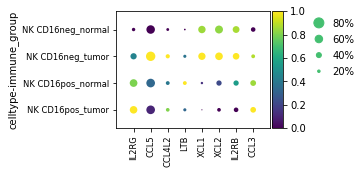

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.8, 0, 0.2, 0.5, 0.25])

In [16]:
sc.pl.dotplot(adata, [g for g in genes if adata2.var.loc[g, 'n_cells']/152 > 0.2], groupby = 'celltype-immune_group', standard_scale = 'var', color_map = 'viridis', save = '/NK_CD16neg_leg.pdf')

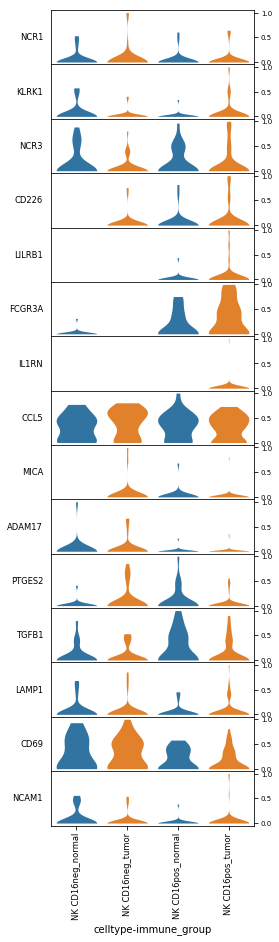

In [8]:
sc.pl.stacked_violin(adata, ['NCR1', 'KLRK1', 'NCR3', 'CD226', 'LILRB1', 'FCGR3A', 'IL1RN',  'CCL5', 'MICA', 'ADAM17', 'PTGES2', 'TGFB1', 'LAMP1', 'CD69', 'NCAM1'], 
                     groupby = 'celltype-immune_group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (4, 15),
                     palette = adata.uns['group_colors'])

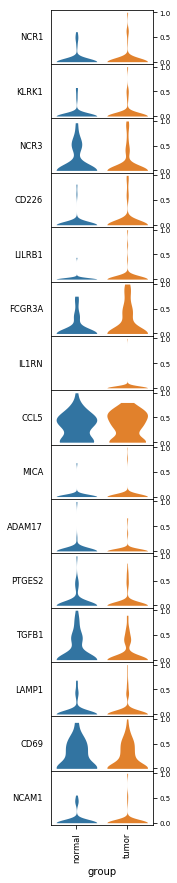

In [9]:
sc.pl.stacked_violin(adata, ['NCR1', 'KLRK1', 'NCR3', 'CD226', 'LILRB1', 'FCGR3A', 'IL1RN',  'CCL5', 'MICA', 'ADAM17', 'PTGES2', 'TGFB1', 'LAMP1', 'CD69', 'NCAM1'], 
                     groupby = 'group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (2, 15),
                     palette = adata.uns['group_colors'])

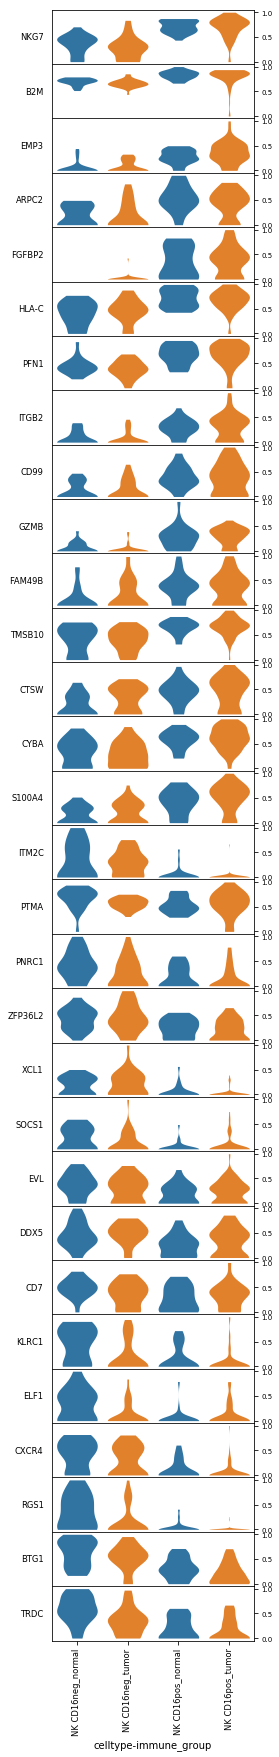

In [10]:
sc.pl.stacked_violin(adata, ['NKG7', 'B2M', 'EMP3', 'ARPC2', 'FGFBP2', 'HLA-C', 'PFN1', 'ITGB2', 'CD99', 'GZMB', 'FAM49B', 'TMSB10', 'CTSW', 'CYBA', 'S100A4', 'ITM2C', 'PTMA', 'PNRC1', 'ZFP36L2', 'XCL1', 'SOCS1', 'EVL', 'DDX5', 'CD7', 'KLRC1', 'ELF1', 'CXCR4', 'RGS1', 'BTG1', 'TRDC'],
                     groupby = 'celltype-immune_group', 
                     standard_scale = 'var', 
                     swap_axes = True,
                     linewidth = 0,
                     figsize = (4, 30),
                     palette = adata.uns['group_colors'])

In [11]:
pos = adata[adata.obs['celltype-immune'] == 'NK CD16pos']
neg = adata[adata.obs['celltype-immune'] == 'NK CD16neg']

In [122]:
sc.tl.rank_genes_groups(pos, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(neg, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(adata, groupby = 'group', method = 'wilcoxon', n_genes = 30000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [123]:
import sys
sys.path.append('/home/jovyan/NC_study/scanpy/scripts')
from tools import returnDEres,exportDEres

In [124]:
posde = returnDEres(pos, 'rank_genes_groups', 'tumor')
negde = returnDEres(neg, 'rank_genes_groups', 'tumor')
adatade = returnDEres(adata, 'rank_genes_groups', 'tumor')

In [125]:
adatade

scores  logfoldchanges         pvals  pvals_adj
TXNIP   3.444510        1.170107  5.720964e-04   1.000000
CHST12  2.909402        1.344026  3.621213e-03   1.000000
FKBP8   2.881655        2.253055  3.955922e-03   1.000000
GNLY    2.762743        0.947006  5.731798e-03   1.000000
CD3E    2.501134        1.857039  1.237963e-02   1.000000
...          ...             ...           ...        ...
GPSM3  -2.933184       -1.127638  3.355048e-03   1.000000
COX5B  -3.095698       -0.998292  1.963499e-03   1.000000
EIF3G  -3.151191       -1.324033  1.626060e-03   1.000000
KLK3   -3.321633       -1.911912  8.949234e-04   1.000000
MSMB   -6.036810       -3.466199  1.571904e-09   0.000035

[21761 rows x 4 columns]

In [45]:
nk_aucellscores = pd.read_csv('dataset/NK_geneset_AUCELL_scores.csv', index_col = 0)
nk_aucellscores

GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                                     0.024446   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                                     0.018116   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                                     0.017744   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                                     0.036457   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                                     0.011174   
...                                                                                   ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                                     0.021347   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                                     0.019500   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                                     0.016738   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                                     0.027856   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                                     0.029122   

                                              GSE13229_IMM_VS_MATURE_NKCELL_DN  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                          0.054434   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                          0.069979   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                          0.035452   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                          0.049283   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                          0.046365   
...                                                                        ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                          0.066812   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                          0.067325   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                          0.072552   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                          0.071644   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                          0.068579   

                                              KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                                        0.158790   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                                        0.155560   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                                        0.067430   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                                        0.088581   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                                        0.119465   
...                                                                                      ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                                        0.100533   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                                        0.153528   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA                                        0.114551   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA                                        0.175827   
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC                                        0.140488   

                                              GO_NATURAL_KILLER_CELL_ACTIVATION  \
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA                           0.102234   
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG                           0.099012   
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA                           0.071412   
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC                           0.026451   
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT                           0.085417   
...                                                                         ...   
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT                           0.173404   
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG                           0.108434   
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA

In [13]:
for i in nk_aucellscores.columns:
    adata.obs[i] = pd.Series(nk_aucellscores[i])

In [16]:
pos = adata[adata.obs['celltype-immune'] == 'NK CD16pos']
neg = adata[adata.obs['celltype-immune'] == 'NK CD16neg']

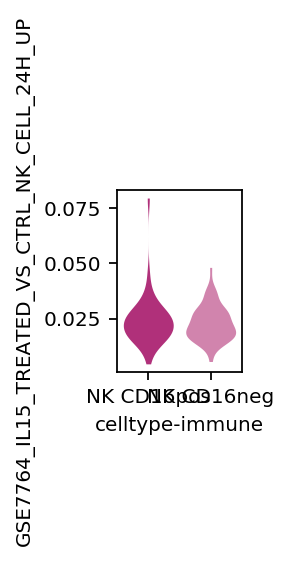

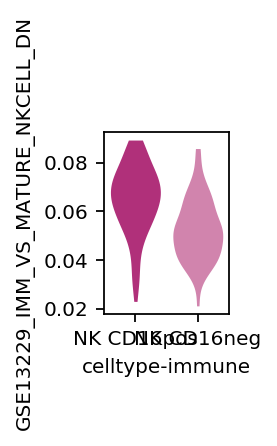

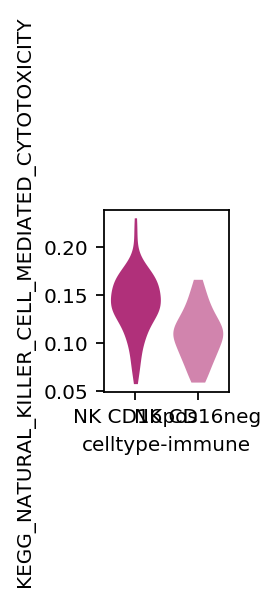

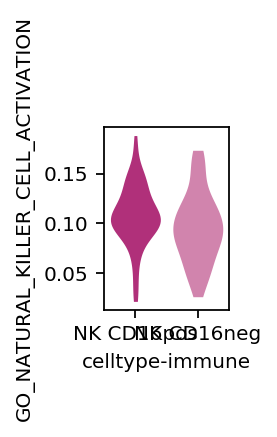

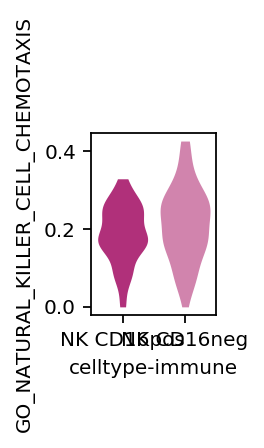

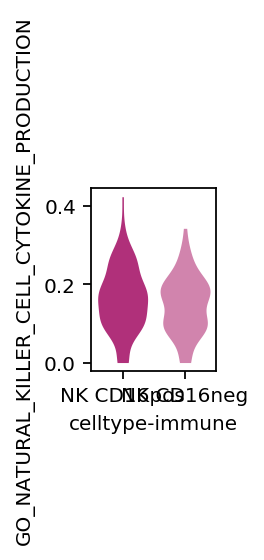

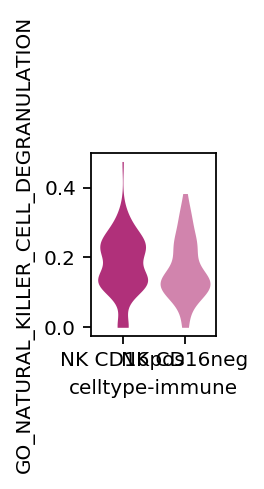

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
for i in nk_aucellscores.columns:
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(adata, [i], ax = ax, groupby = 'celltype-immune', linewidth = 0, size = 0, palette = adata.uns['celltype-immune_colors'], save = '/'+str(i)+'_NK_cell_AUCell.pdf')

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))

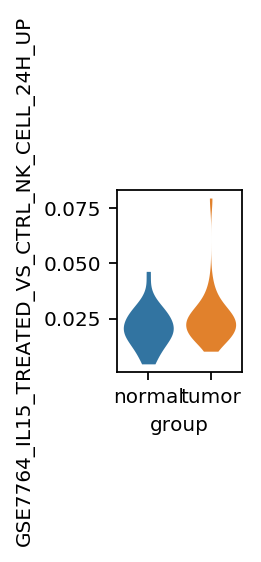

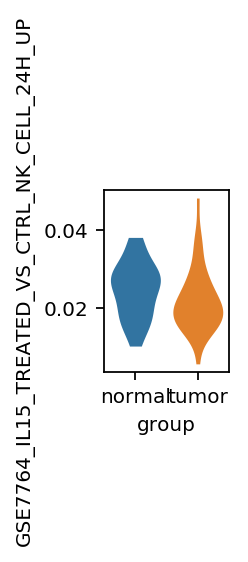

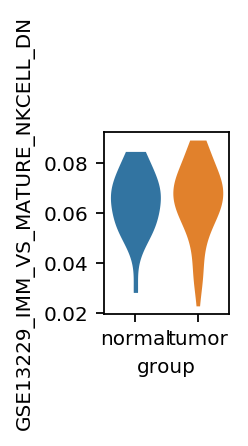

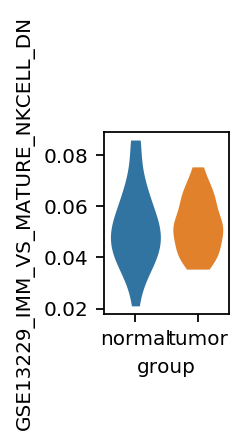

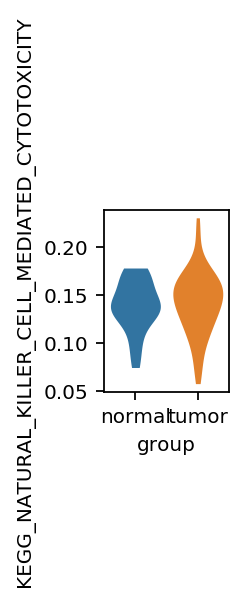

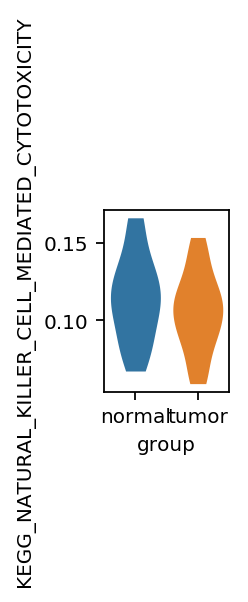

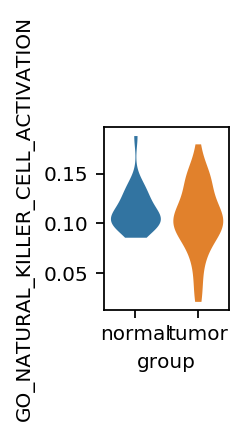

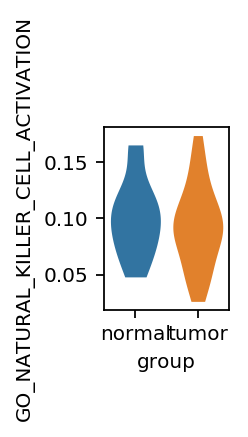

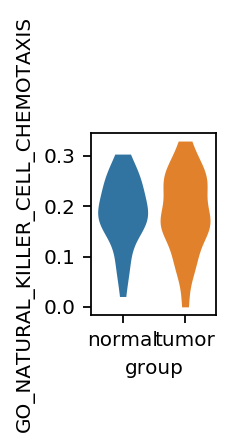

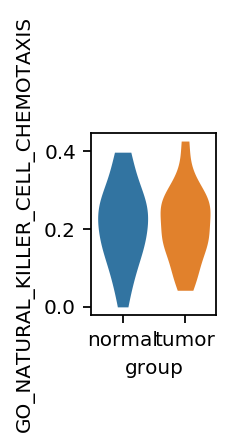

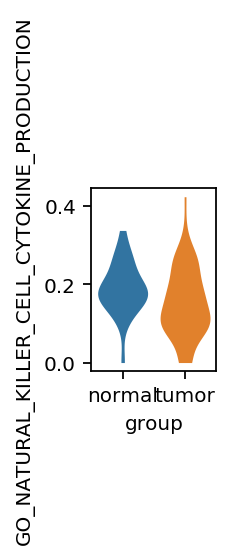

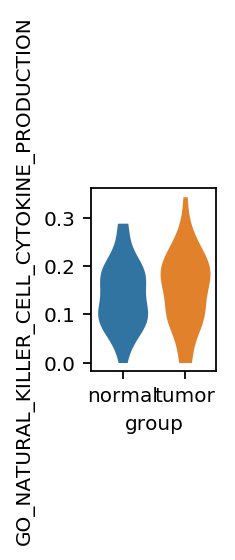

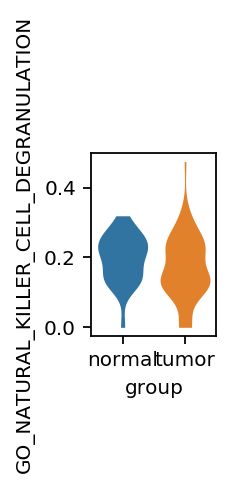

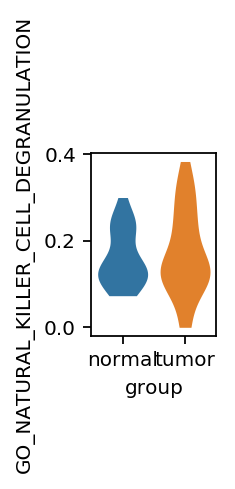

In [17]:
for i in nk_aucellscores.columns:
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(pos, [i], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = pos.uns['group_colors'], save = '/'+str(i)+'_NKCD16pos_cell_AUCell.pdf')
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(neg, [i], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = neg.uns['group_colors'], save = '/'+str(i)+'_NKCD16neg_cell_AUCell.pdf')

In [32]:
from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests
def geneset_ranksums(self, keys, column, groups, fdr = True):
    keys = list(keys)
    x = self.obs[self.obs[column] == groups[0]]
    y = self.obs[self.obs[column] == groups[1]]
    stats = []
    pvals = []
    for key in keys:
#         res = ranksums(x[key], y[key])
        res = mannwhitneyu(x[key], y[key])
        stats.append(res.statistic)
        pvals.append(res.pvalue)
    df = pd.DataFrame(zip(stats, pvals), columns = ['statistic', 'pvals'], index = keys)
    if fdr:
        df['bh_pvals'] = multipletests(df['pvals'], method = 'fdr_bh')[1]
        df['significant'] = df['bh_pvals'] < 0.05
    else:
        df['significant'] = df['pvals'] < 0.05
    return(df)

In [24]:
nk_aucellscores = nk_aucellscores.drop(['GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP', 'GSE13229_IMM_VS_MATURE_NKCELL_DN'], axis = 1)

In [33]:
results_pos = geneset_ranksums(pos, nk_aucellscores.columns, 'group', ('tumor', 'normal'))
results_pos

statistic     pvals  bh_pvals  \
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY      833.0  0.334743  0.418429   
GO_NATURAL_KILLER_CELL_ACTIVATION                   760.0  0.148268  0.247114   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                   860.5  0.422926  0.422926   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION          603.0  0.008863  0.044315   
GO_NATURAL_KILLER_CELL_DEGRANULATION                683.0  0.045027  0.112568   

                                                significant  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY        False  
GO_NATURAL_KILLER_CELL_ACTIVATION                     False  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                     False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION             True  
GO_NATURAL_KILLER_CELL_DEGRANULATION                  False

In [34]:
results_neg = geneset_ranksums(neg, nk_aucellscores.columns, 'group', ('tumor', 'normal'))
results_neg

statistic     pvals  bh_pvals  \
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY      327.0  0.136163  0.417371   
GO_NATURAL_KILLER_CELL_ACTIVATION                   353.0  0.247914  0.417371   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                   386.0  0.439499  0.439499   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION          353.5  0.250423  0.417371   
GO_NATURAL_KILLER_CELL_DEGRANULATION                372.0  0.353222  0.439499   

                                                significant  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY        False  
GO_NATURAL_KILLER_CELL_ACTIVATION                     False  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                     False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION            False  
GO_NATURAL_KILLER_CELL_DEGRANULATION                  False

In [35]:
results_neg.index = ['neg_' + i for i in results_neg.index]

In [36]:
results = results_pos.append(results_neg)

In [37]:
results['bh_pvals'] = multipletests(results['pvals'], method = 'fdr_bh')[1]
results['significant'] = results['bh_pvals'] < 0.05

In [38]:
results

statistic     pvals  \
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY          833.0  0.334743   
GO_NATURAL_KILLER_CELL_ACTIVATION                       760.0  0.148268   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                       860.5  0.422926   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION              603.0  0.008863   
GO_NATURAL_KILLER_CELL_DEGRANULATION                    683.0  0.045027   
neg_KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY      327.0  0.136163   
neg_GO_NATURAL_KILLER_CELL_ACTIVATION                   353.0  0.247914   
neg_GO_NATURAL_KILLER_CELL_CHEMOTAXIS                   386.0  0.439499   
neg_GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION          353.5  0.250423   
neg_GO_NATURAL_KILLER_CELL_DEGRANULATION                372.0  0.353222   

                                                    bh_pvals  significant  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY      0.439499        False  
GO_NATURAL_KILLER_CELL_ACTIVATION                   0.370670        False  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                   0.439499        False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION          0.088630        False  
GO_NATURAL_KILLER_CELL_DEGRANULATION                0.225137        False  
neg_KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  0.370670        False  
neg_GO_NATURAL_KILLER_CELL_ACTIVATION               0.417371        False  
neg_GO_NATURAL_KILLER_CELL_CHEMOTAXIS               0.439499        False  
neg_GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION      0.417371        False  
neg_GO_NATURAL_KILLER_CELL_DEGRANULATION            0.439499        False

In [ ]:
sc.tl.rank_genes_groups(pos, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(neg, groupby = 'group', method = 'wilcoxon', n_genes = 30000)
sc.tl.rank_genes_groups(adata, groupby = 'group', method = 'wilcoxon', n_genes = 30000)

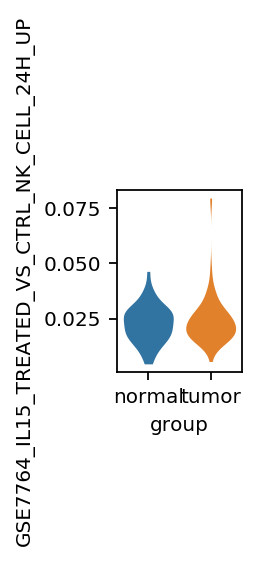

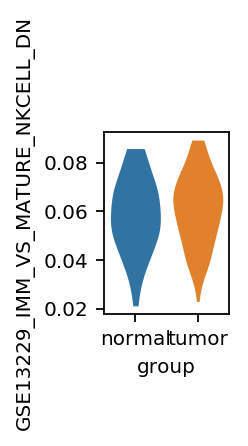

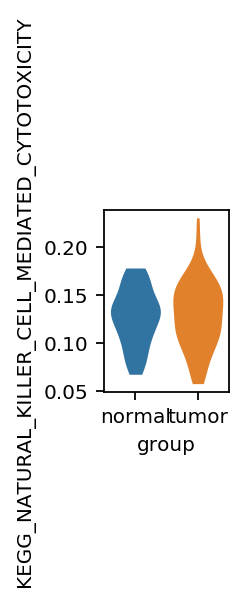

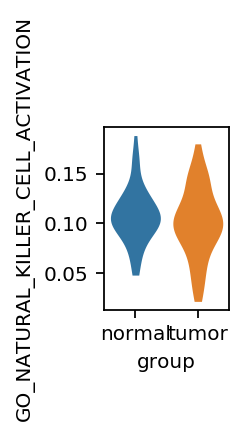

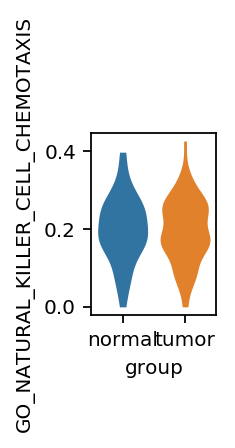

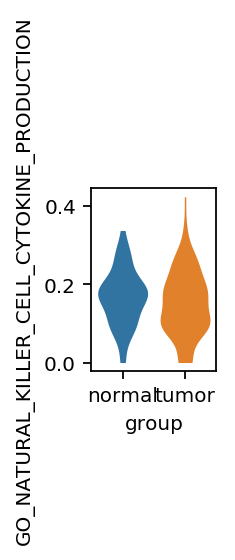

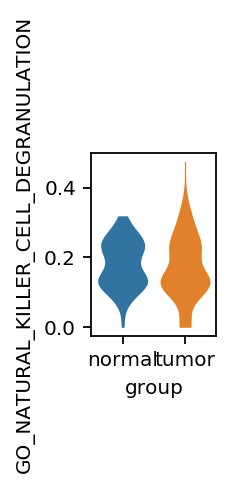

In [129]:
for i in nk_aucellscores.columns:
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(adata, [i], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = adata.uns['group_colors'], save = '/'+str(i)+'_NK_cell_all_AUCell.pdf')

In [130]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def geneset_ranksums(self, keys, column, groups, fdr = True):
    keys = list(keys)
    x = self.obs[self.obs[column] == groups[0]]
    y = self.obs[self.obs[column] == groups[1]]
    stats = []
    pvals = []
    for key in keys:
        res = ranksums(x[key], y[key])
        stats.append(res.statistic)
        pvals.append(res.pvalue)
    df = pd.DataFrame(zip(stats, pvals), columns = ['statistic', 'pvals'], index = keys)
    if fdr:
        df['bh_pvals'] = multipletests(df['pvals'], method = 'fdr_bh')[1]
        df['significant'] = df['bh_pvals'] < 0.05
    else:
        df['significant'] = df['pvals'] < 0.05
    return(df)

In [131]:
results = geneset_ranksums(adata, nk_aucellscores.columns, 'celltype-immune', ('NK CD16pos', 'NK CD16neg'))
results

statistic         pvals  \
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP      0.299636  7.644548e-01   
GSE13229_IMM_VS_MATURE_NKCELL_DN                 5.287249  1.241696e-07   
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY   5.932035  2.992021e-09   
GO_NATURAL_KILLER_CELL_ACTIVATION                2.416053  1.568979e-02   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               -1.682134  9.254284e-02   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION       1.062001  2.882351e-01   
GO_NATURAL_KILLER_CELL_DEGRANULATION             1.378705  1.679857e-01   

                                                    bh_pvals  significant  
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP     7.644548e-01        False  
GSE13229_IMM_VS_MATURE_NKCELL_DN                4.345937e-07         True  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  2.094415e-08         True  
GO_NATURAL_KILLER_CELL_ACTIVATION               3.660950e-02         True  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               1.619500e-01        False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION      3.362743e-01        False  
GO_NATURAL_KILLER_CELL_DEGRANULATION            2.351800e-01        False

In [132]:
results = geneset_ranksums(adata, nk_aucellscores.columns, 'group', ('tumor', 'normal'))
results

statistic     pvals  bh_pvals  \
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP      0.057475  0.954167  0.954167   
GSE13229_IMM_VS_MATURE_NKCELL_DN                 0.794734  0.426768  0.746844   
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY   0.241790  0.808943  0.954167   
GO_NATURAL_KILLER_CELL_ACTIVATION               -1.078143  0.280970  0.746844   
GO_NATURAL_KILLER_CELL_CHEMOTAXIS               -0.214043  0.830513  0.954167   
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION      -1.234712  0.216938  0.746844   
GO_NATURAL_KILLER_CELL_DEGRANULATION            -0.826444  0.408552  0.746844   

                                                significant  
GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP           False  
GSE13229_IMM_VS_MATURE_NKCELL_DN                      False  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY        False  
GO_NATURAL_KILLER_CELL_ACTIVATION                     False  
GO_NATURAL_KILLER_CELL_CHEMOTAXIS                     False  
GO_NATURAL_KILLER_CELL_CYTOKINE_PRODUCTION            False  
GO_NATURAL_KILLER_CELL_DEGRANULATION                  False

In [41]:
nk_res_aucellscores = pd.read_csv('dataset/NK_residency_geneset_AUCELL_scores.csv', index_col = 0)
nk_res_aucellscores

Resident  Circulating
SLX-15736SIGAA9HTHM2BBXXs_4_AACTCCCAGACGCACA  0.034298     0.012070
SLX-15736SIGAA9HTHM2BBXXs_4_ACGGGCTAGAACTCGG  0.030389     0.011164
SLX-15736SIGAA9HTHM2BBXXs_4_AGCTCTCAGTTGAGTA  0.018385     0.023838
SLX-15736SIGAA9HTHM2BBXXs_4_ATCTACTCACCTTGTC  0.008861     0.022361
SLX-15736SIGAA9HTHM2BBXXs_4_ATTCTACGTAGGGACT  0.032613     0.053879
...                                                ...          ...
SLX-16362SIGAA3HWFTVBBXXs_4_GCGCAGTAGAAACCAT  0.029594     0.055659
SLX-16362SIGAA3HWFTVBBXXs_4_GTAACTGCACCGCTAG  0.058378     0.014519
SLX-16362SIGAA3HWFTVBBXXs_4_TGGCTGGTCGCGCCAA  0.014257     0.021077
SLX-16362SIGAA3HWFTVBBXXs_4_TTGCCGTAGCTGTCTA  0.035545     0.039058
SLX-16362SIGAA3HWFTVBBXXs_4_TTGTAGGTCACTTATC  0.039942     0.030720

[152 rows x 2 columns]

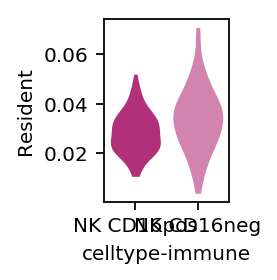

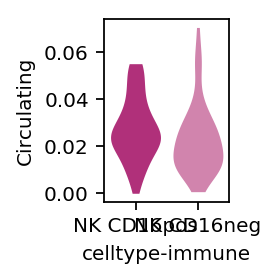

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.ylim(0,.18)
sc.set_figure_params(dpi=80, dpi_save=300, vector_friendly=False, fontsize=9, figsize=(1,1.5))
for i in nk_res_aucellscores.columns:
    adata.obs[i] = pd.Series(nk_res_aucellscores[i])
    ax = sns.violinplot()
    ax.grid(False)
    sc.pl.violin(adata, [i], ax = ax, groupby = 'celltype-immune', linewidth = 0, size = 0, palette = adata.uns['celltype-immune_colors'], save = '/'+str(i)+'_NK_cell_residency_AUCell.pdf')

In [49]:
test = nk_res_aucellscores.join(nk_aucellscores[['KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY', 'GO_NATURAL_KILLER_CELL_ACTIVATION']])

In [50]:
results = geneset_ranksums(adata, test.columns, 'celltype-immune', ('NK CD16pos', 'NK CD16neg'))
results

statistic         pvals  \
Resident                                           1962.0  1.890607e-03   
Circulating                                        2095.0  8.392007e-03   
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY     1162.0  1.513392e-09   
GO_NATURAL_KILLER_CELL_ACTIVATION                  2089.0  7.885847e-03   

                                                    bh_pvals  significant  
Resident                                        3.781215e-03         True  
Circulating                                     8.392007e-03         True  
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY  6.053569e-09         True  
GO_NATURAL_KILLER_CELL_ACTIVATION               8.392007e-03         True

In [44]:
results = geneset_ranksums(adata, nk_res_aucellscores.columns, 'celltype-immune', ('NK CD16pos', 'NK CD16neg'))
results

statistic     pvals  bh_pvals  significant
Resident        1962.0  0.001891  0.003781         True
Circulating     2095.0  0.008392  0.008392         True

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/lymphoid.h5ad'

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0


AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

In [112]:
bdata = adata[(adata.obs['celltype'] == 'B cell')]
bdata

View of AnnData object with n_obs × n_vars = 148 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors',

In [113]:
module = ['MARCH1', 'MARCH8', 'ABCB9', 'ACE', 'ACTR10', 'ACTR1A', 'ACTR1B', 'AP1B1', 'AP1G1', 'AP1M1', 'AP1M2', 'AP1S1', 'AP1S2', 'AP1S3', 'AP2A1', 'AP2A2', 'AP2B1', 'AP2M1', 'AP2S1', 'AP3B1', 'AP3D1', 'ARF1', 'ATG5', 'AZGP1', 'B2M', 'BCAP31', 'CALR', 'CANX', 'CAPZA1', 'CAPZA2', 'CAPZA3', 'CAPZB', 'CCL19', 'CCL21', 'CCR7', 'CD1A', 'CD1B', 'CD1C', 'CD1D', 'CD1E', 'CD207', 'CD209', 'CD36', 'CD68', 'CD74', 'CD8A', 'CENPE', 'CHUK', 'CLEC4A', 'CLEC4M', 'CLTA', 'CLTC', 'CTSD', 'CTSE', 'CTSF', 'CTSH', 'CTSL', 'CTSS', 'CTSV', 'CYBA', 'CYBB', 'DCTN1', 'DCTN2', 'DCTN3', 'DCTN4', 'DCTN5', 'DCTN6', 'DNM2', 'DYNC1H1', 'DYNC1I1', 'DYNC1I2', 'DYNC1LI1', 'DYNC1LI2', 'DYNLL1', 'DYNLL2', 'E7ENX8', 'ERAP1', 'ERAP2', 'FCER1G', 'FCGR1A', 'FCGR1B', 'FCGR2B', 'FCGRT', 'FGL2', 'HFE', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOA', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQA2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'HLA-E', 'HLA-F', 'HLA-G', 'HLA-H', 'ICAM1', 'IDE', 'IFI30', 'IKBKB', 'IKBKG', 'ITGAV', 'ITGB5', 'KIF11', 'KIF15', 'KIF18A', 'KIF22', 'KIF23', 'KIF26A', 'KIF2A', 'KIF2B', 'KIF2C', 'KIF3A', 'KIF3B', 'KIF3C', 'KIF4A', 'KIF4B', 'KIF5A', 'KIFAP3', 'KLC1', 'KLC2', 'LAG3', 'LGMN', 'LILRB2', 'LNPEP', 'MICA', 'MICB', 'MR1', 'NCF1', 'NCF2', 'NCF4', 'NOD1', 'NOD2', 'OSBPL1A', 'PDIA3', 'PSAP', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB10', 'PSMB11', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSME1', 'PSME2', 'PSME3', 'PSME4', 'PSMF1', 'PYCARD', 'RAB10', 'RAB27A', 'RAB32', 'RAB33A', 'RAB34', 'RAB35', 'RAB3B', 'RAB3C', 'RAB4A', 'RAB5B', 'RAB6A', 'RAB7A', 'RAB8B', 'RACGAP1', 'RELB', 'RFTN1', 'RILP', 'SAR1B', 'SEC13', 'SEC22B', 'SEC23A', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SH3GL2', 'SLC11A1', 'SNAP23', 'SPTBN2', 'TAP1', 'TAP2', 'TAPBP', 'TAPBPL', 'THBS1', 'TRAF6', 'TREM2', 'TREX1', 'VAMP3', 'VAMP8', 'WAS', 'YTHDF1']
sc.tl.score_genes(bdata, module, score_name = 'Antigen processing and presentation_score', use_raw=True)

computing score 'Antigen processing and presentation_score'


Trying to set attribute `.obs` of view, making a copy.


    finished: added
    'Antigen processing and presentation_score', score of gene set (adata.obs) (0:00:00)


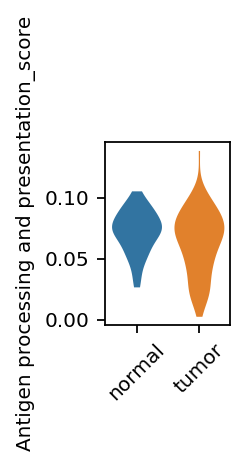

In [114]:
ax = sns.violinplot()
ax.grid(False)
sc.pl.violin(bdata, ['Antigen processing and presentation_score'], ax = ax, groupby = 'group', linewidth = 0, size = 0, palette = adata.uns['group_colors'], rotation = 45, save = '/B cell_Antigen processing and presentation_score.pdf')

In [6]:
genesets = pd.read_csv('/home/jovyan/NC_study/scanpy/datasets/Bcell_genesets.txt', sep = '\t')
for gs in genesets.columns:
    sc.tl.score_genes(bdata, [g for g in genesets[gs] if g is not np.nan], score_name = str(gs)+'_score', use_raw=True)

computing score 'MEMORY_vs_GC_UP_score'
    finished: added
    'MEMORY_vs_GC_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GC_vs_MEMORY_UP_score'
    finished: added
    'GC_vs_MEMORY_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'NAIVE_vs_GC_UP_score'
    finished: added
    'NAIVE_vs_GC_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'GC_vs_NAIVE_UP_score'
    finished: added
    'GC_vs_NAIVE_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'MEMORY_vs_NAIVE_UP_score'
    finished: added
    'MEMORY_vs_NAIVE_UP_score', score of gene set (adata.obs) (0:00:00)
computing score 'NAIVE_vs_MEMORY_UP_score'
    finished: added
    'NAIVE_vs_MEMORY_UP_score', score of gene set (adata.obs) (0:00:00)


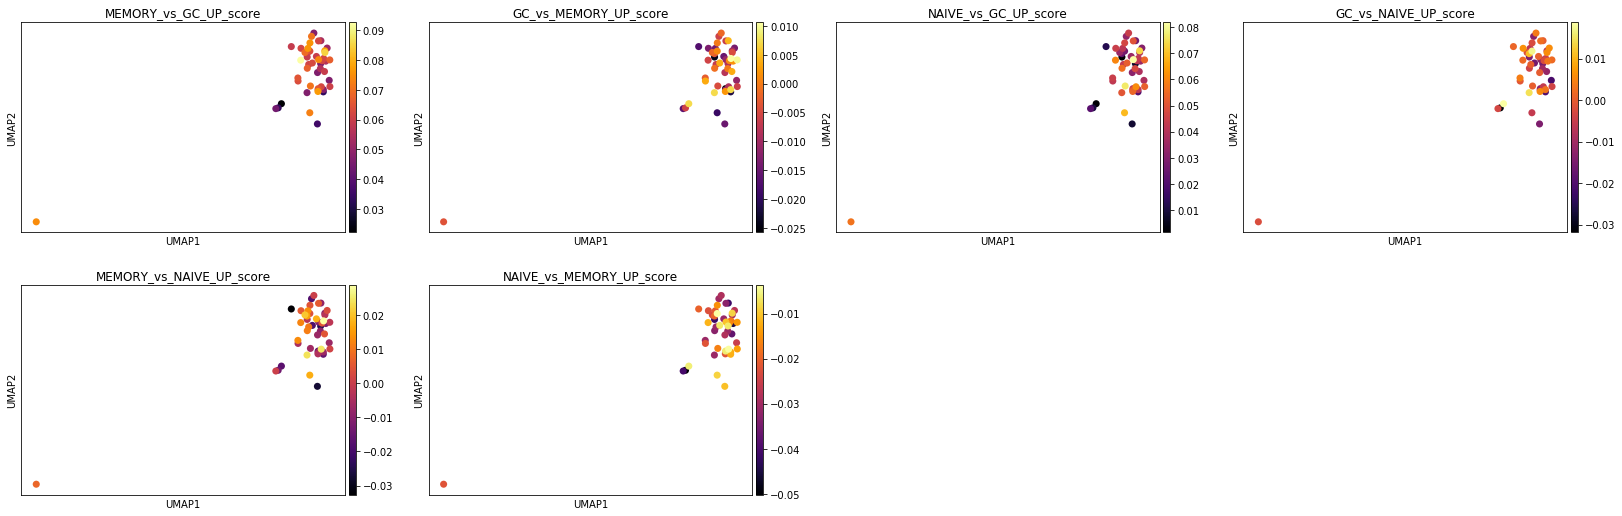

In [7]:
sc.pl.umap(bdata, color = [str(gs)+'_score' for gs in genesets.columns], color_map = 'inferno', size = 200)

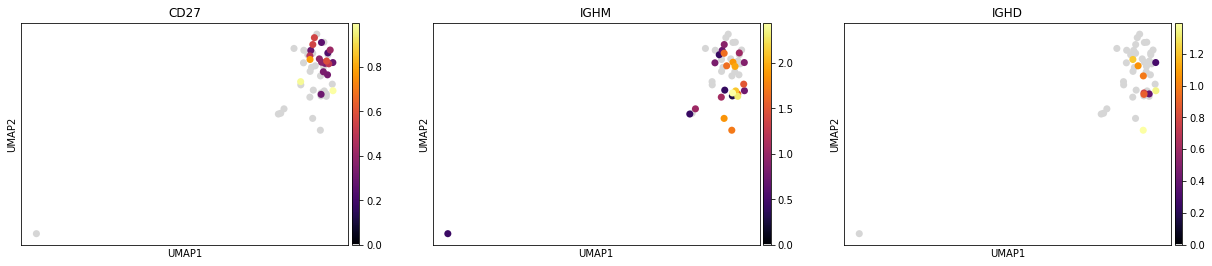

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('inferno', 256)
newcolors = viridis(np.linspace(0, 1, 256))
grey = np.array([215/256, 215/256, 215/256, 1])
newcolors[:1, :] = grey
newcmp = ListedColormap(newcolors)

sc.pl.umap(bdata, color = ['CD27', 'IGHM', 'IGHD'],size = 200, color_map = newcmp)

In [44]:
bdata.raw.var.index.get_loc('CD27')

13234

In [45]:
bdata.raw.var.index.get_loc('IGHD')

15481

In [47]:
bdata.raw.X[:,13234][bdata.raw.X[:,13234] > 0].shape

(1, 19)

In [48]:
bdata.raw.X[:,15481][bdata.raw.X[:,15481] > 0].shape

(1, 9)

In [49]:
test = bdata.raw.X[:,(13234,15481)]

In [68]:
test = pd.DataFrame(test.toarray(), columns = ['CD27', 'IGHD'])

In [79]:
# non-naive/unassigned
test[(test['CD27'] > 0) & (test['IGHD'] > 0)].shape

(4, 2)

In [80]:
# Memory
test[(test['CD27'] > 0) & (test['IGHD'] == 0)].shape

(15, 2)

In [81]:
# naive
test[(test['CD27'] == 0) & (test['IGHD'] > 0)].shape

(5, 2)

In [82]:
# non-naive/unassigned
test[(test['CD27'] == 0) & (test['IGHD'] == 0)].shape

(23, 2)

In [3]:
adata

AnnData object with n_obs × n_vars = 1694 × 2178 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'Treg_score', 'CD4 NV/CM rest_score', 'CD4/CD8 rest_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score', 'CD69+Trm_score', 'CD69-Trm_score', 'Trm_score', 'Tcm/Tem_score', 'GSE41867 Chronic-acute CD8+ Up_score', 'GSE41870 CD8+ LCMV Chronic-Acute UP_score', 'GSE9650 Chronic vs acute LCMV-specific CD8 T cells_score', 'celltype-immune', 'celltype-immune_group', 'K562_score', 'ADCC_score', 'cytokine_score', 'common_score', '__is_in_cluster__'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype-immune_colors', 'celltype_colors', 'dendr

In [4]:
adata.uns['group_colors']

array(['#1f77b4', '#ff7f0e'], dtype=object)

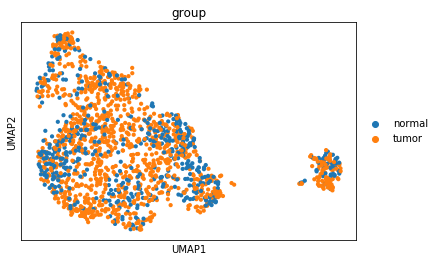

In [5]:
sc.pl.umap(adata, color = 'group')